# Saturating feedback

> Show that saturating feedback leads to absence of T1s

In [ ]:
#| default_exp saturating

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [ ]:
#|export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm
import CE_simulation.phase_analysis as ana

In [ ]:
#|export

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy import spatial, ndimage

from collections import Counter
import itertools

from copy import deepcopy
import os
import pickle

In [ ]:
#|export

from joblib import Parallel, delayed
import gc

In [ ]:
#|export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.nn import relu

from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

In [ ]:
#|export

from typing import Sequence, Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso); importlib.reload(drs);
importlib.reload(dis); importlib.reload(hes); importlib.reload(ecm); importlib.reload(ana);

In [ ]:
def get_width_height(mesh, q=0.8, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)])

    delta = np.quantile(centroids, axis=0, q=q)-np.quantile(centroids, axis=0, q=1-q,)
    return delta


In [ ]:
def get_width_height_tri(mesh, q=0.8, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([v.coords for key, v in mesh.vertices.items()
                          if (not v.is_bdry()) and (not v._vid in exclude)])

    delta = np.quantile(centroids, axis=0, q=q)-np.quantile(centroids, axis=0, q=1-q,)
    return delta


## Random stuff

In [ ]:
orientations = ["parallel", "orthogonal"]
k_relaxs = [1, 1/10, 1/20]
k_passives = [4, 8, 12]
noise_gaussians = [0.05, 0.1, 0.15]
noise_dynamics = [0, 0.2]
feedbacks = ["perimeter", "area"]
use_voronois = [False, True]


reps = np.array([1, 2, 3]) # number of replicates
to_do = list(itertools.product(orientations, k_relaxs, k_passives, [0.1,], ["perimeter",], [0,], [False,], reps))
to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.05, 0.15], ["perimeter",], [0,], [False,], reps))
to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.1,], ["area",], [0,], [False,], reps))
to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.1,], ["perimeter",], [0.2,], [False,], reps))
to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.1,], ["perimeter",], [0,], [True,], reps))

len(to_do)

84

In [ ]:
sim_path = "/data/Nikolas/GBE_simulation/runs/parameter_scans/parameter_scan_new_post_T1/"

In [ ]:
n_files = sorted([len(os.listdir(sim_path+x)) for x in os.listdir(sim_path)])

len(n_files), sum(['last_flipped_edges.pickle' in os.listdir(sim_path+x) for x in os.listdir(sim_path)])

(84, 80)

In [ ]:
[x for x in os.listdir(sim_path) if not 'last_flipped_edges.pickle' in os.listdir(sim_path+x)]

# most which are stuck are "area" sims with "parallel"

['orientation_parallel_kRelax_0.1_kPassive_8_noiseGaussian_0.1_feedback_area_noiseDynamic_0_voronoi_False_randomSeed_2',
 'orientation_parallel_kRelax_0.1_kPassive_8_noiseGaussian_0.1_feedback_area_noiseDynamic_0_voronoi_False_randomSeed_3',
 'orientation_parallel_kRelax_0.1_kPassive_8_noiseGaussian_0.1_feedback_area_noiseDynamic_0_voronoi_False_randomSeed_1',
 'orientation_orthogonal_kRelax_0.05_kPassive_4_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_randomSeed_3']

In [ ]:
Counter([x.split("_")[3] for x in os.listdir(sim_path) if len(os.listdir(sim_path+x)) < 500])


Counter({'0.1': 21, '0.05': 18})

In [ ]:
Counter([x.split("_")[3] for x in os.listdir(sim_path) if len(os.listdir(sim_path+x)) > 500])

# no clear role for k_passive, noise_gaussian. But higher balancing rate is more stable, basically always.
# area also a lot more unstable, makes sense. interestingly, noise is stable

Counter({'0.1': 27, '1': 18})

In [ ]:
Counter([x.split('_')[-1] for x in os.listdir(sim_path) if len(os.listdir(sim_path+x)) < 500])


Counter({'3': 13, '2': 13, '1': 13})

In [ ]:
Counter([x.split('_')[-1] for x in os.listdir(sim_path) if len(os.listdir(sim_path+x)) > 500])


Counter({'1': 15, '3': 15, '2': 15})

## Parameter sweep stability

In [ ]:
sim_path = "/data/Nikolas/GBE_simulation/runs/parameter_scans/parameter_scan_new_post_T1/"

In [ ]:
files = sorted([x for x in os.listdir(sim_path) if 'cutoff' in x])

In [ ]:
files

['orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_1',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_2',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.3_randomSeed_1',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.3_randomSeed_2',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.4_randomSeed_1',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.4_randomSeed_2',
 'orientation_orthogonal_kRelax_0.1_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_1',
 'orientation_orth

In [ ]:
[x for x in files if not 'last_flipped_edges.pickle' in os.listdir(sim_path+x)]


['orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_1',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_2']

In [ ]:
[x for x in files if len(os.listdir(sim_path+x)) < 600]

# cutoff 0.3 seems to be sufficient.

['orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_1',
 'orientation_orthogonal_kRelax_0.05_kPassive_8_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.25_randomSeed_2']

In [ ]:
drs.create_rect_initial

<function CE_simulation.drosophila.create_rect_initial(nx, ny, noise=0, initial_strain=0, isogonal=0, orientation='orthogonal', boundaries=None, w_passive=0, w_passive_lr=0, bdry_x=None, bdry_y=None, random_seed=0)>

In [ ]:
initial_strain = 0.1
initial_strain = np.sqrt(1+2*initial_strain)-1 # due to convention

initial_strain

0.09544511501033215

In [ ]:
n_x = 26
n_y = 20

mesh, _ = ecm.create_hard_disk_initial(n_x=n_x, n_y=n_y, eta=0.85, initial_strain=0.1, remove_boundary_dx=0.75,
                                       n_chains=10, chain_time=100, progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/ecmc.py:190: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


In [ ]:
len(mesh.vertices)

450

In [ ]:
mesh_bridge, _ = drs.create_rect_initial(18, 25, noise=0.1, initial_strain=0, orientation='parallel',
                                         boundaries=None, w_passive=0, w_passive_lr=0)

(-9.61389301908247, 9.63610698091753, -12.214047744771802, 12.205116647362916)

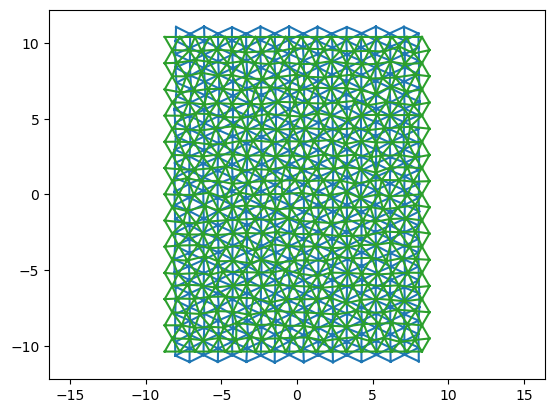

In [ ]:
mesh.triplot()
mesh_bridge.triplot()

plt.axis("equal")

In [ ]:
mesh_cable, _ = drs.create_rect_initial(18, 25, noise=0.1, initial_strain=0, orientation='orthogonal',
                                        boundaries=None, w_passive=0, w_passive_lr=0)

In [ ]:
len(mesh_cable.vertices), len(mesh_bridge.vertices)

(450, 450)

(-8.909410781194289, 8.905523720688539, -13.47610698091753, 13.47389301908247)

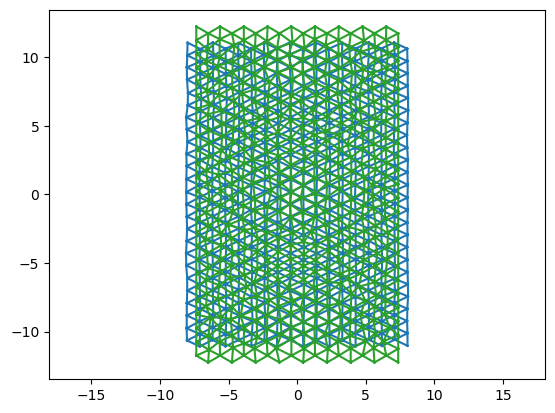

In [ ]:
mesh.triplot()
mesh_cable.triplot()

plt.axis("equal")

## Phase diags check which ones worked

In [ ]:
initial_strains = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
etas = [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
reps = np.array([1, 2, 3]) # number of replicates
to_do = list(itertools.product(initial_strains, etas, reps))

len(to_do)

180

In [ ]:
sim_path = "/data/Nikolas/GBE_simulation/runs/hard_disks/perimeter_phase_diag_new_post_T1/"

In [ ]:
n_files = sorted([len(os.listdir(sim_path+x)) for x in os.listdir(sim_path)])

len(n_files), sum(['last_flipped_edges.pickle' in os.listdir(sim_path+x) for x in os.listdir(sim_path)])

(94, 74)

In [ ]:
initial_strains = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])  
etas = [0.45, 0.55, 0.65, 0.75, 0.85,]
reps = np.array([1,]) # number of replicates # 1, 2, 3
to_do = list(itertools.product(initial_strains, etas, reps))

len(to_do)

30

In [ ]:
orientations = ["parallel", "orthogonal"]
k_relaxs = [1, 1/10, 1/20]
k_passives = [4, 8, 12]
noise_gaussians = [0.05, 0.1, 0.15]
noise_dynamics = [0, 0.2]
feedbacks = ["perimeter", "area"]
use_voronois = [False, True]
k_cutoff = [0.2, 0.25, 0.3, 0.4]

reps = np.array([1, 2,]) # number of replicates # 1, 2, 3
#to_do = list(itertools.product(orientations, k_relaxs, k_passives, [0.1,], ["perimeter",], [0,], [False,], [0.2,], reps))
#to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.05, 0.15], ["perimeter",], [0,], [False,], [0.2,], reps))
#to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.1,], ["area",], [0,], [False,], [0.2,], reps))
#to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.1,], ["perimeter",], [0.2,], [False,], [0.2,], reps))
#to_do = to_do + list(itertools.product(orientations, [1/10,], [8,], [0.1,], ["perimeter",], [0,], [True,], [0.2,], reps))

to_do = list(itertools.product(orientations, k_relaxs, [8], [0.1,], ["perimeter",], [0,], [False,], k_cutoff, reps))

len(to_do)

48

## Cartoon for slide show

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

bgr =  LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0032F5-0032F5-7A7A7A-F1030F-F10410
    (0.000, (0.000, 0.196, 0.961)),
    (0.250, (0.000, 0.196, 0.961)),
    (0.500, (0.478, 0.478, 0.478)),
    (0.750, (0.945, 0.012, 0.059)),
    (1.000, (0.945, 0.016, 0.063))))

def get_color(x, vmin=.6, vmax=1.4):
    return np.array(bgr((np.clip(x, vmin, vmax)-vmin)/(vmax-vmin)))
    

In [ ]:
# elastic energy parameters

tol, maxiter = (1e-4, 50000)
mod_bulk = 1
mod_shear = 1
angle_penalty = 1000
bdry_penalty = 0

epsilon_l = (1e-3, 1e-3)  # mollifying parameters to ensure energy differentiability
mod_area = 0; mod_perimeter = 0 # no area-perimeter elasticity

bdr_weight = 1 # avoid problems at boundary
rel_elastic_modulus = 0

# package all into a single dict to pass to the optimizer method
energy_args = {'mod_bulk': mod_bulk, 'mod_shear': mod_shear,
               'angle_penalty': angle_penalty, 'bdry_penalty': bdry_penalty, 'epsilon_l': epsilon_l,
               'mod_area': mod_area, 'mod_perimeter': mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
mesh_disorder, _ = ecm.create_hard_disk_initial(14, 14, eta=0.45, noise_gaussian=0.075, initial_strain=0.2,
                                                remove_boundary_dx=0.75, n_chains=300, chain_time=200, isogonal=0.1,
                                                progress_bar=True,)


  0%|          | 0/300 [00:00<?, ?it/s]

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/ecmc.py:190: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


In [ ]:
mesh_disorder.optimize_cell_shape(**optimizer_args)

In [ ]:
mesh_disorder_iso, _ = ecm.create_hard_disk_initial(14, 14, eta=0.2, noise_gaussian=0.075, initial_strain=0,
                                                remove_boundary_dx=0.75, n_chains=300, chain_time=200, isogonal=0.1,
                                                progress_bar=True,)


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
mesh_disorder_iso.optimize_cell_shape(**optimizer_args)

In [ ]:
mesh_order, _ = ecm.create_hard_disk_initial(12, 16, eta=0.9, noise_gaussian=0.075, initial_strain=0.2, orientation='bridge',
                                             remove_boundary_dx=0.75, n_chains=3, chain_time=10, isogonal=0.1,
                                             progress_bar=True,)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
sol = mesh_order.optimize_cell_shape(**optimizer_args)

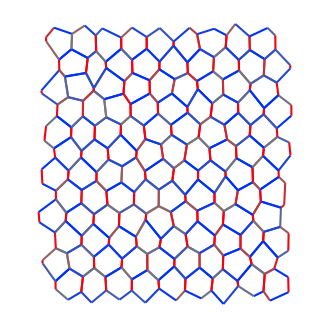

In [ ]:
#mesh_order.triplot()

fig = plt.figure(figsize=(4,4))

mesh_order.cellplot(edge_colors={key: get_color(val) for key, val in mesh_order.get_rel_tension().items()})

plt.axis("equal")
plt.axis("off")
#plt.savefig("/home/nikolas/Documents/UCSB/streichan/fridtjof paper/sketch_order.pdf")

In [ ]:
mesh_order.get_vertex_angles()

(-5.5619338040040125, 5.776051242315661, -6.95242897026778, 6.184788718213995)

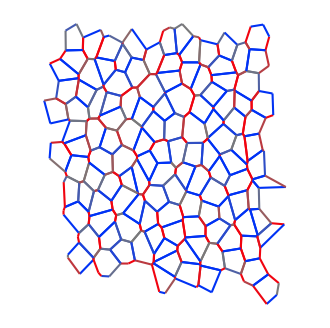

In [ ]:
#mesh_disorder.triplot()
fig = plt.figure(figsize=(4,4))
mesh_disorder.cellplot(edge_colors={key: get_color(val) for key, val in mesh_disorder.get_rel_tension().items()})

plt.axis("equal")
plt.axis("off")

#plt.savefig("/home/nikolas/Documents/UCSB/streichan/fridtjof paper/sketch_disorder.pdf")

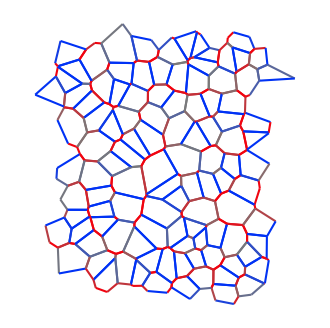

In [ ]:
fig = plt.figure(figsize=(4,4))
mesh_disorder_iso.cellplot(edge_colors={key: get_color(val) for key, val in mesh_disorder_iso.get_rel_tension().items()})

plt.axis("equal")
plt.axis("off")

plt.savefig("/home/nikolas/Documents/UCSB/streichan/fridtjof paper/sketch_disorder_iso.pdf")

## Saturating feedback

In [ ]:
#| export

def excitable_dt(Ts, m=4, k_cutoff=0):
    dT_dt = Ts**m - k_cutoff*Ts**(m+1)
    dT_dt -= dT_dt.mean()
    return dT_dt

In [ ]:
#| export

def excitable_dt_act_pass(Ts: NDArray[Shape["3"], Float], Tps: NDArray[Shape["3"], Float],
                          k=1, m=2, k_cutoff=0, is_active=True, subtract_passive=True,
                         ) -> Tuple[NDArray[Shape["3"],Float],NDArray[Shape["3"],Float]]:
    """
    Time derivative of tensions under excitable tension model, including passive tension.
    
    Perimeter version -- keeps triangle perimeter fixed. Perimeter of the passive tension may vary of course.
    
    Implements the following equations:
        d_dt T = T^m
        d_dt T_passive = -k*T_passive
    
    with the following additions:
        - a -k_cutoff*T^(m+1) term which cuts of excitable feedback at large tensions for numerical stability
        - projection of the d_dt T - vector on triangle-perimter-preserving edge length changes
    
    For m==1 (no excitable tension feedback), we implement a special case:
        d_dt T = -k*(T-1)
    i.e. tensions relax back to equilateral. This will be useful later to model completely
    passive edges with no excitable dynamics.
    
    Parameters
    ----------
    Ts : (3,) array
        active tensions
    Tps : (3,) array
        passive tensions
    k : float
        passive tension relaxation rate
    m : float
        excitable tension exponent
    k_cutoff : 
        cutoff for excitable tension. 0 = no cutoff.
        
    Returns
    -------
    dT_dt : (3,) array
        time derivative of active tension
    dTp_dt : (3,) array
        time derivative of passive tension


    """
    if is_active:
        if subtract_passive:
            dT_dt = (Ts-Tps)**m - k_cutoff*(Ts-Tps)**(m+1) - k*Tps
        else:
            dT_dt = Ts**m - k_cutoff*Ts**(m+1) - k*Tps
        dTp_dt = -k*Tps
        dT_dt -= dT_dt.mean()
    else:
        dT_dt = -k*(Ts-Tps)
        dTp_dt = np.zeros(3)
        dT_dt -= dT_dt.mean()
    return dT_dt, dTp_dt

In [ ]:
#| export

# define saturating feedback function

def saturating_dt(Ts, T_minus=0, T_c=1, T_plus=2):
    dT_dt = -(Ts-T_minus)*(Ts-T_c)*(Ts-T_plus)
    dT_dt -= dT_dt.mean()
    return dT_dt

In [ ]:
#| export

# define saturating feedback function

def saturating_dt_act_pass(Ts: NDArray[Shape["3"], Float], Tps: NDArray[Shape["3"], Float],
                           T_minus=0, T_c=1, T_plus=2, k=1, is_active=True, subtract_passive=True,
                           ) -> Tuple[NDArray[Shape["3"],Float],NDArray[Shape["3"],Float]]:
    """
    Time derivative of tensions under saturating positive feedback model, including passive tension.
    
    Parameters
    ----------
    Ts : (3,) array
        active tensions
    Tps : (3,) array
        passive tensions
    T_minus, T_c, T_plus: float
        Fixed points of tension feedback
    k : float
        passive tension relaxation rate
    is_active : bool
        Whether the given triangle is active. Otherwise, relax to 1.
        
    Returns
    -------
    dT_dt : (3,) array
        time derivative of active tension
    dTp_dt : (3,) array
        time derivative of passive tension

    """
    if is_active:
        if subtract_passive:
            dT_dt = -((Ts-Tps)-T_minus)*((Ts-Tps)-T_c)*((Ts-Tps)-T_plus) - k*Tps
        else:
            dT_dt = -(Ts-T_minus)*(Ts-T_c)*(Ts-T_plus) - k*Tps
        dTp_dt = -k*Tps
        dT_dt -= dT_dt.mean()
    else:
        dT_dt = -k*(Ts-1)
        dTp_dt = np.zeros(3)
        dT_dt -= dT_dt.mean()
    return dT_dt, dTp_dt

## Run simulation

In [ ]:
mesh_initial, property_dict= drs.create_rect_initial(18, 22, noise=0.1, initial_strain=0.125,
                                                     orientation='orthogonal', isogonal=0,
                                                     boundaries=None, w_passive=0, w_passive_lr=0,
                                                     random_seed=15) # 3

passive_ids = property_dict['passive_faces']
passive_cells = property_dict['passive_cells']

# n = 14, 14. let's try a bigger sample size to see if everything still works.

In [ ]:
len(mesh_initial.vertices)

396

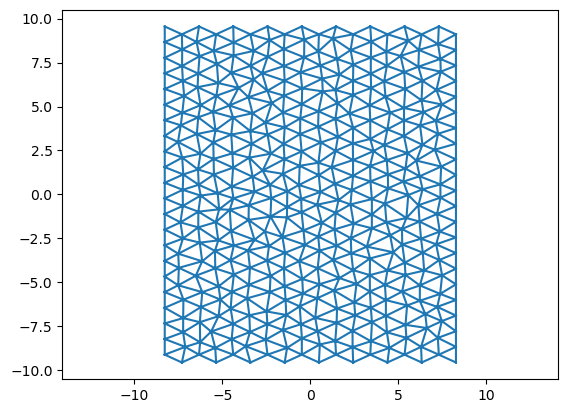

In [ ]:
mesh_initial.triplot()
plt.axis("equal");

In [ ]:
dT_m = np.median([np.linalg.norm(excitable_dt(np.array([he.rest for he in fc.hes]), m=4, k_cutoff=0.3))
                 for fc in mesh_initial.faces.values()])

dT = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0, T_c=1, T_plus=3.33))
                for fc in mesh_initial.faces.values()])
dT_sat = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0, T_c=1, T_plus=1.2))
                for fc in mesh_initial.faces.values()])


dT_m, dT, dT_sat, dT/dT_sat

(0.4886150608071662,
 0.44315272802810785,
 0.03451249070371163,
 12.840357765904423)

In [ ]:
## Set parameters


T_minus = 0
T_c = 1

dt = .05 # time step
n_steps = 500

minimal_l = 0.0 # minimal edge length, lower edge lengths trigger T1
tri_mod_area = .01 # triangle area regularization

In [ ]:
## simulation loop - define as function to use joblib later.

# with keep_in_memory=True, this uses way too much memory with joblib, while being ok if run individually?

def run_simulation(T_plus, subtract_passive, k=0.5, n_steps=n_steps, dt=dt, forbid_reflip=50, keep_in_memory=False, log_rate=20,
                   verbose=False):
    """Local function to run simulation. To save memory, keeping all meshes in RAM is optional."""
    # define the feedback parameters
    
    def params_pattern(fid):
        if fid in passive_ids:
            return {"T_minus": T_minus, "T_c": T_c, "T_plus": T_plus, "k": 4*k, "is_active": False, "subtract_passive": subtract_passive} 
        return {"T_minus": T_minus, "T_c": T_c, "T_plus": T_plus, "k": k, "is_active": True, "subtract_passive": subtract_passive} 
    
    # initialize the relevant quantities for the measurement
    ltc_series= []
    valence_series= []
    delta_series = []
    
    # set up simulation loop
    times = [0]
    last_flipped_edges = [[]]
    mesh = deepcopy(mesh_initial)
    mesh_previous = deepcopy(mesh)
    if keep_in_memory:
        meshes = [mesh_previous]
    else:
        meshes = [mesh_previous]
    
    mesh = deepcopy(meshes[-1])
    for i in tqdm(range(n_steps)):
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=saturating_dt_act_pass, params=params_pattern, rhs_rest_shape=None)
        # flatten triangulation
        sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, reset_intrinsic=True, return_sol=True)
        if sol["status"] != 0:
            break
            
        # set voronoi positions
        mesh.set_voronoi()
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False, optimizer_args=None)
        if verbose:
            if failed_flip:
                print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
            if flipped and not failed_flip:
                print(f"tpt {i}: flip {flipped}")
        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        if keep_in_memory:
            meshes.append(mesh_previous)
        if not keep_in_memory and ((i%log_rate) == 0) and (i > 0): # if I am not storing all meshes
            meshes.append(mesh_previous)
        # make measurements
        valence_series.append(ecm.get_valences(mesh))
        ltc_dist = tns.angles_shape(np.array(list(mesh.get_vertex_angles(exclude=None, method="dual").values())).T)
        ltc_series.append(ltc_dist)
        delta_series.append(get_width_height(mesh))
    # post-processing
    last_flipped_edges.append([])
    T1_rate = np.array([len(x) for x in last_flipped_edges[1:]]) / len(meshes[0].vertices)  # dt!! - should not use that. just use raw t1s.
    ltc_series = np.stack(ltc_series)
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    if keep_in_memory:
        return (T_plus, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series)    
    
    else:
        return T_plus, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series

In [ ]:
%%time

# run a single simulation
data_true = run_simulation(T_plus=4, subtract_passive=True, k=0.5, n_steps=500, dt=0.005, forbid_reflip=20, keep_in_memory=False, log_rate=10,
                           verbose=True)
# k =0.5
_, meshes_true, last_flipped_edges_true, T1_rate_true, ltc_series_true, valence_series_true, delta_series_true = data_true

  0%|          | 0/500 [00:00<?, ?it/s]

tpt 0: flip [823]
tpt 4: flip [1020]
tpt 11: flip [1704, 1999]
tpt 13: flip [238]
tpt 14: flip [60, 987]
tpt 15: flip [1104]
tpt 17: flip [1896]
tpt 18: flip [1485]
tpt 22: flip [2037, 1959, 493]
tpt 23: flip [2023, 1075, 501]
tpt 24: flip [1575]
tpt 26: flip [1579]
tpt 28: flip [787, 742]
tpt 30: flip [163, 2053, 757]
tpt 32: flip [1789, 1471, 268]
tpt 33: flip [1779, 204, 1900]
tpt 34: flip [1275, 1305]
tpt 35: flip [840, 762]
tpt 36: flip [1995]
tpt 37: flip [396, 223, 97]
tpt 38: flip [961]
tpt 39: flip [540]
tpt 40: flip [607]
tpt 41: flip [766, 1500]
tpt 42: flip [234, 2013]
tpt 43: flip [723]
tpt 44: flip [1755]
tpt 45: flip [1830]
tpt 46: flip [861]
tpt 47: flip [2035, 1408, 900]
tpt 48: flip [531, 1474]
tpt 49: flip [363, 1417]
tpt 50: flip [1060, 252]
tpt 51: flip [52, 1264]
tpt 52: flip [505, 1858]
tpt 53: flip [417, 357]
tpt 54: flip [1974, 1204]
tpt 55: flip [1560, 241, 1380, 445, 879]
tpt 56: flip [1428, 1251]
tpt 57: flip [1410, 46, 664, 1702]
tpt 58: flip [612, 1030, 15

tpt 355: flip [1881]
tpt 356: flip [588]
tpt 357: flip [81]
tpt 358: flip [213, 1177]
tpt 359: flip [528]
tpt 360: flip [366, 1194]
tpt 361: flip [1848]
tpt 362: flip [444, 2115, 1110]
tpt 363: flip [1860]
tpt 365: flip [327]
tpt 366: flip [1077]
tpt 367: flip [600, 1827, 558]
tpt 368: flip [1303, 1488]
tpt 369: flip [2071, 2133]
tpt 370: flip [1890]
tpt 371: flip [1029, 1242, 1533]
tpt 372: flip [2106, 892]
tpt 373: flip [582]
tpt 375: flip [852]
tpt 376: flip [1308]
tpt 377: flip [651, 324, 1740]
tpt 378: flip [1539]
tpt 379: flip [1023]
tpt 381: flip [243, 1716]
tpt 382: flip [183, 768, 1647]
tpt 383: flip [1473]
tpt 384: flip [1893, 567, 921, 2107]
tpt 385: flip [193, 1972, 589]
tpt 386: flip [1134]
tpt 387: flip [1842]
tpt 388: flip [711, 1608]
tpt 391: flip [1255]
tpt 392: flip [907, 1578]
tpt 393: flip [892, 1378]
tpt 394: flip [423]
tpt 395: flip [1974, 2119]
tpt 396: flip [2043]
tpt 397: flip [1188]
tpt 398: flip [324, 1599, 267, 1197, 1278]
tpt 399: flip [1906, 123]
tpt 400: 

(0.43, 0.55)

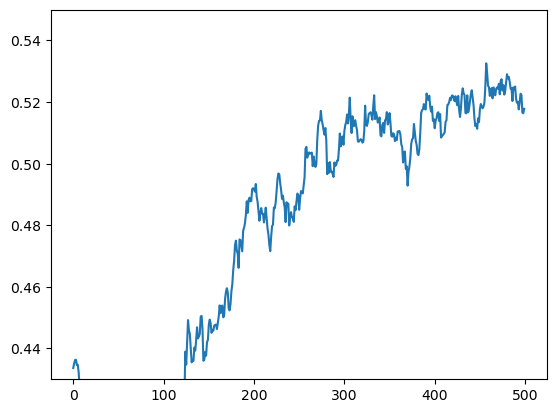

In [ ]:
plt.plot(np.median(ltc_series_true[:,0,:], axis=-1)/np.pi) # k =0.5.

plt.ylim([0.43, 0.55])

[<matplotlib.lines.Line2D>]

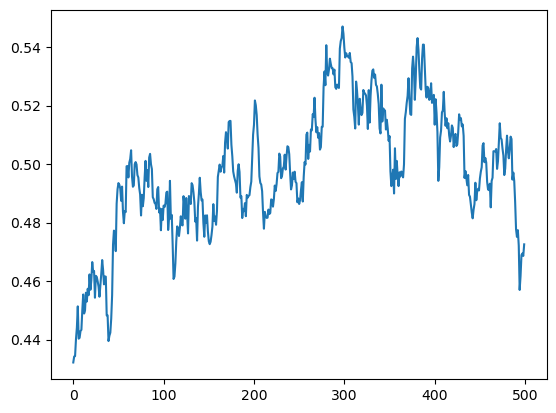

In [ ]:
plt.plot(np.median(ltc_series_true[:,0,:], axis=-1)/np.pi) #  k =10

[<matplotlib.lines.Line2D>]

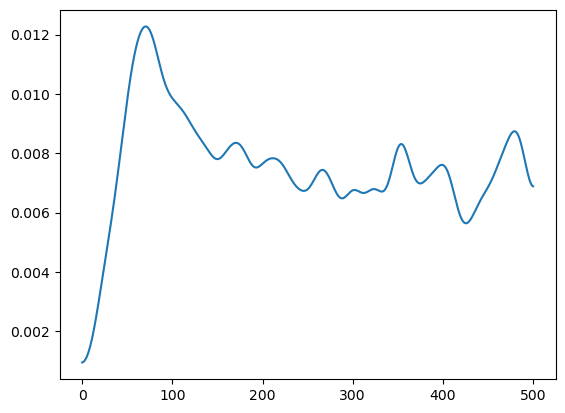

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate_true, sigma=10)) ## for k =10

[<matplotlib.lines.Line2D>]

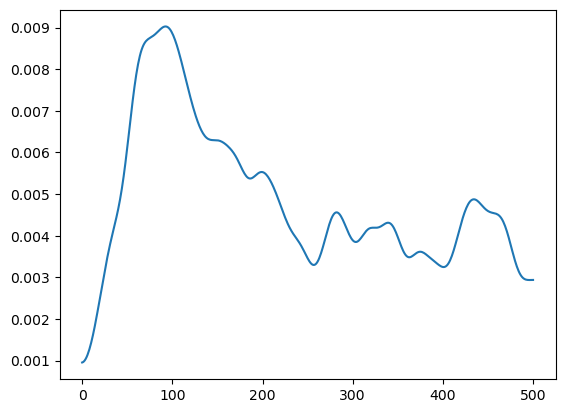

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate_true, sigma=10)) ## for k =1

In [ ]:
elongation_true = np.sqrt(np.exp(delta_series_true[:,0])/np.exp(delta_series_true[:,1]))

In [ ]:
bdry_x, bdry_y = (16, 11)

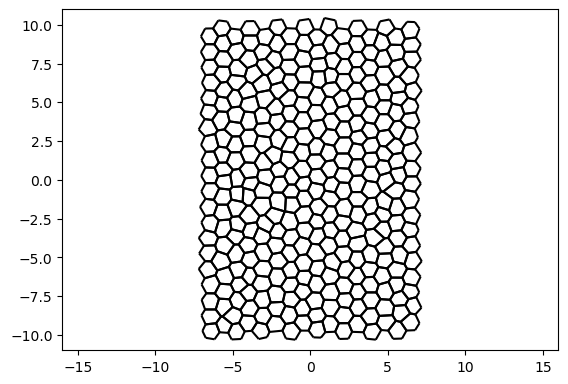

In [ ]:
meshes_true[0].cellplot()

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

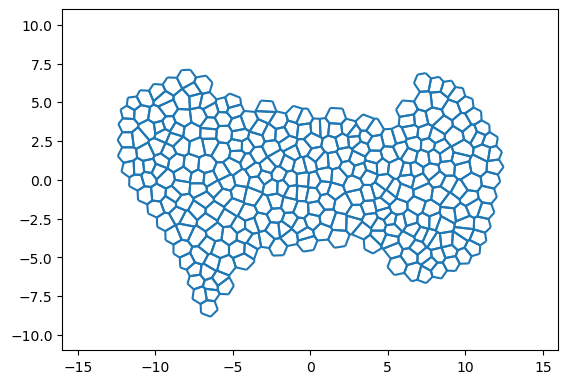

In [ ]:
meshes_true[30].cellplot(edge_colors={key: "tab:blue" for key in meshes_true[0].hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")  # with T-Tp

In [ ]:
# now let's see what is up with the "parallel" initial condition. this seems to work very poorly for
# the "False" prescription. why??

# reca

In [ ]:
%%time

# run a single simulation
data = run_simulation(T_plus=4, subtract_passive=False, k=10, n_steps=500, dt=0.005, forbid_reflip=20, keep_in_memory=False, log_rate=10,
                      verbose=True) # k=6
# k = 0.5
_, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series = data

# bridge initial cond: k= 4 is too low. 1.6 for k=8. 1.6 for k=12

  0%|          | 0/500 [00:00<?, ?it/s]

tpt 0: flip [823]
tpt 3: flip [1020]
tpt 15: flip [1896]
tpt 16: flip [501, 1575, 987, 60]
tpt 18: flip [238]
tpt 21: flip [2037, 1471, 1305, 493]
tpt 22: flip [2023]
tpt 23: flip [1579]
tpt 24: flip [1075, 757, 840]
tpt 26: flip [1789, 1900, 1704, 204]
tpt 29: flip [223, 1779, 1500]
tpt 31: flip [607, 1485, 1995]
tpt 32: flip [2013, 268, 2035]
tpt 33: flip [396, 540]
tpt 34: flip [762, 363]
tpt 35: flip [1974]
tpt 36: flip [766, 1755, 961]
tpt 37: flip [1830]
tpt 38: flip [52, 531, 1858]
tpt 39: flip [1408]
tpt 40: flip [234, 723]
tpt 41: flip [163]
tpt 42: flip [861, 1428, 1848]
tpt 43: flip [1845]
tpt 44: flip [933, 505, 1264]
tpt 45: flip [1104, 1417]
tpt 46: flip [1990, 417, 1236]
tpt 47: flip [963, 1258, 727, 1489, 787, 1060, 228, 2053]
tpt 48: flip [1410, 1204, 1380, 2067, 1377, 612, 546]
tpt 49: flip [370]
tpt 50: flip [556, 1030, 1596, 1251, 241]
tpt 51: flip [252]
tpt 52: flip [1426, 1117, 940]
tpt 54: flip [928]
tpt 55: flip [858, 357, 886]
tpt 56: flip [1834, 1645]
tpt 57: 

tpt 297: flip [1449, 256, 1023, 1299, 720]
tpt 298: flip [1797, 747, 372, 1387, 952, 1384]
tpt 299: flip [519, 2097, 264, 2013]
tpt 300: flip [885, 694, 1933]
tpt 301: flip [1377]
tpt 303: flip [1119, 412]
tpt 304: flip [279, 1555]
tpt 305: flip [393]
tpt 306: flip [82]
tpt 307: flip [1992, 2067, 1107, 321, 2094]
tpt 308: flip [1785, 672]
tpt 309: flip [994, 2124, 238, 1596]
tpt 310: flip [424, 1474, 1726, 268]
tpt 311: flip [1716, 856, 928, 949]
tpt 312: flip [2103, 1630, 154, 855, 1579]
tpt 313: flip [873, 1815, 318]
tpt 317: flip [1285, 871]
tpt 318: flip [1713]
tpt 319: flip [879, 2128]
tpt 320: flip [1402, 97, 1834, 568]
tpt 321: flip [552, 1248, 357, 1177]
tpt 322: flip [1483]
tpt 323: flip [751, 180]
tpt 324: flip [867, 1719, 1302, 2083]
tpt 325: flip [1408, 628, 1, 2007, 1416, 1837]
tpt 326: flip [2035, 759, 2023, 555]
tpt 327: flip [511, 796, 1245]
tpt 328: flip [877, 390, 711]
tpt 329: flip [1221, 2058, 516, 1572, 912, 936, 978, 1384, 1444]
tpt 330: flip [465, 150, 651]
tpt 3

In [ ]:
elongation = np.sqrt(np.exp(delta_series[:,0])/np.exp(delta_series[:,1]))

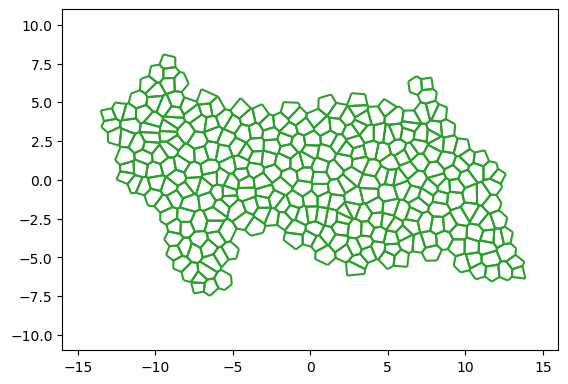

In [ ]:
meshes_true[-1].cellplot(edge_colors={key: "tab:green" for key in mesh_initial.hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

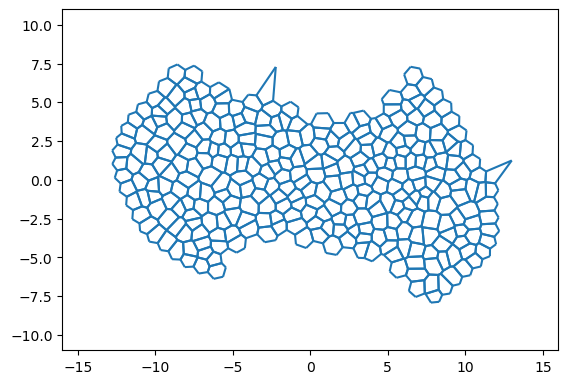

In [ ]:
meshes[-1].cellplot(edge_colors={key: "tab:blue" for key in mesh_initial.hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

In [ ]:
np.median(ltc_series[-1], axis=-1) / np.array([np.pi, 1])  # a lot more cable-like and more anisotropic than True

array([0.43701962, 0.40606547])

In [ ]:
np.median(ltc_series_true[-1], axis=-1) / np.array([np.pi, 1])

array([0.48969322, 0.44562377])

<matplotlib.legend.Legend>

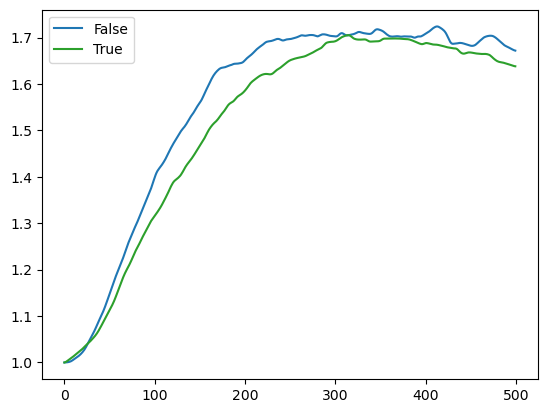

In [ ]:
plt.plot(elongation, color="tab:blue", label="False")
plt.plot(elongation_true, color="tab:green", label="True")

plt.legend()

# big difference in elongation between true and false for small sample size. not so large for bigger sample

<matplotlib.legend.Legend>

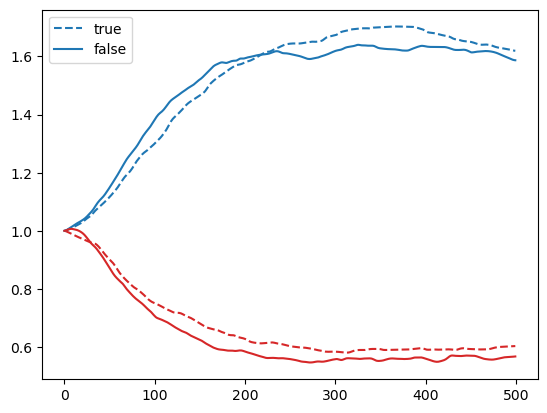

In [ ]:
plt.plot(np.exp(delta_series_true[:,0]), color="tab:blue", ls="dashed", label="true")
plt.plot(np.exp(delta_series_true[:,1]), color="tab:red", ls="dashed")


plt.plot(np.exp(delta_series[:,0]), color="tab:blue", label="false")
plt.plot(np.exp(delta_series[:,1]), color="tab:red")

plt.legend()

In [ ]:
passive_vs_time = np.array([[he.passive/he.rest for he in m.hes.values()] for m in meshes])
passive_vs_time_true = np.array([[he.passive/he.rest for he in m.hes.values()] for m in meshes_true])

In [ ]:
(passive_vs_time[40] < 0.25).mean(), (passive_vs_time_true[40] < 0.25).mean()

(0.9346257889990983, 0.630297565374211)

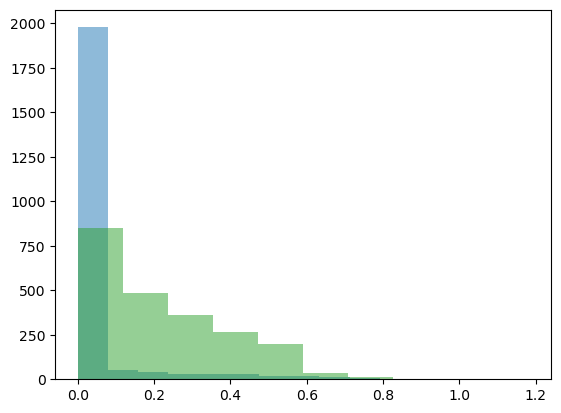

In [ ]:
plt.hist(passive_vs_time[40], alpha=0.5, color="tab:blue");
plt.hist(passive_vs_time_true[40], alpha=0.5, color="tab:green");

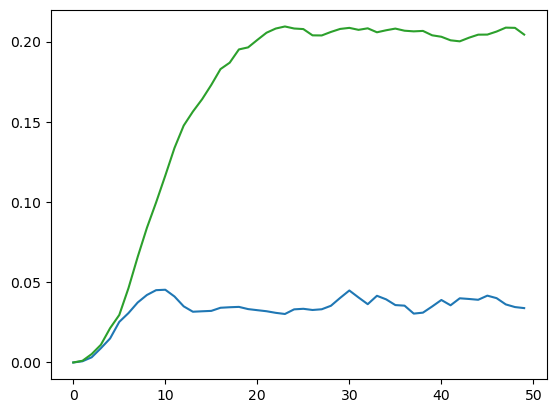

In [ ]:
plt.plot(passive_vs_time.mean(axis=1), color="tab:blue");
plt.plot(passive_vs_time_true.mean(axis=1), color="tab:green");

# average 10% of tension is passive for False, 30% for true.

In [ ]:
1/0.3

3.3333333333333335

### Now try the saturating version

In [ ]:
## get timescale of tension changes to calibrate

dT = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0, T_c=1, T_plus=4))
                for fc in mesh_initial.faces.values()])
dT_sat = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0, T_c=1, T_plus=1.2))
                for fc in mesh_initial.faces.values()])


dT, dT_sat, dT/dT_sat

(0.5699091634584148, 0.03451249070371163, 16.513127619535272)

In [ ]:
# euler step should be small enough for sure. why is the influence of the flow in LTC space so weak once 

In [ ]:
%%time

# run a single simulation

timescale = 16

# what happens if we drastically increase k ? 0.5 -> 4. If one does this, the cable effect becomes stronger again.

data_sat = run_simulation(T_plus=1.2, subtract_passive=False, k=10/timescale, n_steps=500, dt=timescale*0.005, # k=2 previously
                          forbid_reflip=20, keep_in_memory=False, log_rate=10, verbose=True)
_, meshes_sat, last_flipped_edges_sat, T1_rate_sat, ltc_series_sat, valence_series_sat, delta_series_sat = data_sat

  0%|          | 0/500 [00:00<?, ?it/s]

tpt 0: flip [823]
tpt 10: flip [238]
tpt 16: flip [840]
tpt 29: flip [1848]
tpt 30: flip [1575]
tpt 34: flip [223, 1075]
tpt 37: flip [601, 1845]
tpt 38: flip [1305]
tpt 40: flip [1858]
tpt 41: flip [501]
tpt 45: flip [1590, 1489]
tpt 46: flip [766]
tpt 48: flip [1854, 2053]
tpt 49: flip [1884]
tpt 50: flip [703]
tpt 51: flip [1272]
tpt 53: flip [1822]
tpt 54: flip [757, 1218]
tpt 55: flip [1483]
tpt 56: flip [1614]
tpt 57: flip [708, 355]
tpt 58: flip [1041]
tpt 60: flip [1719]
tpt 61: flip [1605]
tpt 62: flip [958, 1485]
tpt 63: flip [651]
tpt 64: flip [513]
tpt 65: flip [316, 1258, 546, 163, 1071, 1918, 954]
tpt 66: flip [720, 1645, 1623, 961]
tpt 67: flip [1632]
tpt 68: flip [1030]
tpt 69: flip [753, 1753, 525, 1045, 1768, 382, 540]
tpt 70: flip [649, 241, 762]
tpt 71: flip [408, 1732, 399]
tpt 72: flip [1287]
tpt 73: flip [85, 1783, 865, 550, 1377]
tpt 74: flip [1285, 60, 2121, 1177]
tpt 75: flip [1426, 1551]
tpt 76: flip [1033, 699]
tpt 77: flip [1707, 1251]
tpt 78: flip [648, 12

tpt 395: flip [759]
tpt 396: flip [937]
tpt 397: flip [1945, 1260]
tpt 399: flip [2020]
tpt 400: flip [699]
tpt 401: flip [322, 822]
tpt 402: flip [1248, 90, 1768]
tpt 403: flip [1728, 1066]
tpt 404: flip [1275, 885, 462]
tpt 405: flip [607]
tpt 406: flip [1234, 1278]
tpt 407: flip [1765, 768]
tpt 409: flip [849]
tpt 410: flip [577, 1030]
tpt 412: flip [718, 27]
tpt 413: flip [1779, 1630]
tpt 414: flip [538]
tpt 415: flip [159]
tpt 416: flip [1272, 723, 1255]
tpt 418: flip [201]
tpt 421: flip [550]
tpt 422: flip [655]
tpt 423: flip [534, 1038, 2115]
tpt 424: flip [1086, 651, 2104]
tpt 425: flip [847, 1024]
tpt 427: flip [924, 945]
tpt 428: flip [1047, 714, 1725, 916, 1998]
tpt 429: flip [576, 2119, 892]
tpt 430: flip [2100, 717, 940]
tpt 431: flip [1401]
tpt 432: flip [441]
tpt 434: flip [75]
tpt 435: flip [1279]
tpt 436: flip [2028, 394]
tpt 438: flip [82, 85, 288]
tpt 439: flip [1389]
tpt 440: flip [1728, 1995, 1410, 879]
tpt 441: flip [918, 2013, 2010, 1743]
tpt 445: flip [1068]
tpt

In [ ]:
elongation_sat = np.sqrt(np.exp(delta_series_sat[:,0])/np.exp(delta_series_sat[:,1]))

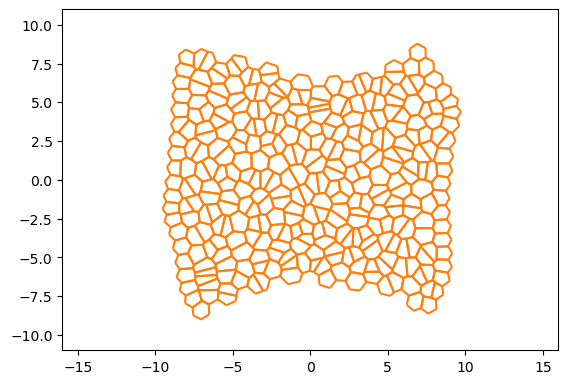

In [ ]:
meshes_sat[35].cellplot(edge_colors={key: "tab:orange" for key in mesh_initial.hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

[<matplotlib.lines.Line2D>]

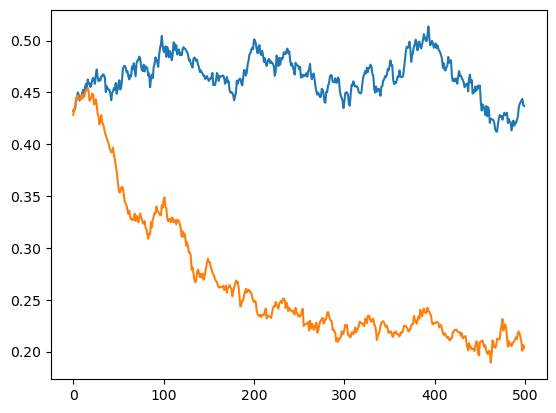

In [ ]:
plt.plot(np.median(ltc_series[:,0], axis=-1)/np.pi)

plt.plot(np.median(ltc_series_sat[:,0], axis=-1)/np.pi)

<matplotlib.legend.Legend>

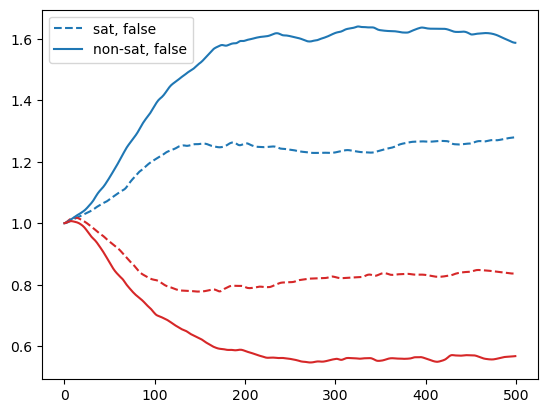

In [ ]:
plt.plot(np.exp(delta_series_sat[:,0]), color="tab:blue", ls="dashed", label="sat, false")
plt.plot(np.exp(delta_series_sat[:,1]), color="tab:red", ls="dashed")


plt.plot(np.exp(delta_series[:,0]), color="tab:blue", label="non-sat, false")
plt.plot(np.exp(delta_series[:,1]), color="tab:red")

plt.legend()

Text(0, 0.5, 'T1 rate')

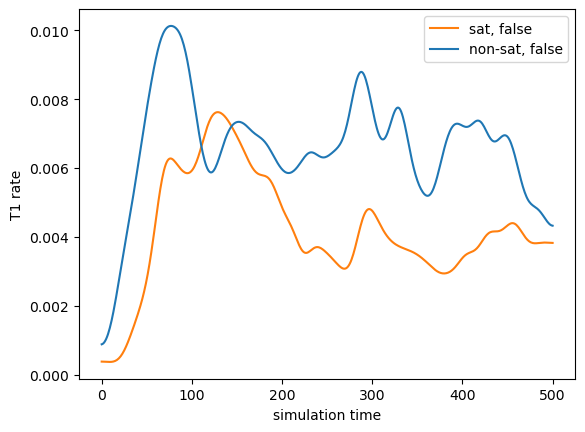

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate_sat, sigma=10), color="tab:orange", label="sat, false")
plt.plot(ndimage.gaussian_filter1d(T1_rate, sigma=10), color="tab:blue", label="non-sat, false")

plt.legend()

plt.xlabel("simulation time")
plt.ylabel("T1 rate")

# -> drastic drop in T1 rate is abolished if one uses higher relaxation rates! now drop is weaker

In [ ]:
%%time

# run a single simulation

timescale = 16

# what happens if we drastically increase k ? 0.5 -> 4. If one does this, the cable effect becomes stronger again.

data_sat_true = run_simulation(T_plus=1.2, subtract_passive=True, k=1/timescale, n_steps=500, dt=timescale*0.005, # 2 here
                               forbid_reflip=20, keep_in_memory=False, log_rate=10, verbose=True)
_, meshes_sat_true, last_flipped_edges_sat_true, T1_rate_sat_true, ltc_series_sat_true, valence_series_sat_true, delta_series_sat_true = data_sat_true


  0%|          | 0/500 [00:00<?, ?it/s]

tpt 0: flip [823]
tpt 8: flip [238]
tpt 18: flip [840]
tpt 31: flip [1848, 223]
tpt 32: flip [2053]
tpt 34: flip [601]
tpt 35: flip [1075]
tpt 38: flip [1575]
tpt 42: flip [766]
tpt 44: flip [1845]
tpt 46: flip [1858]
tpt 47: flip [501]
tpt 48: flip [1489]
tpt 49: flip [163, 1590]
tpt 50: flip [1305]
tpt 52: flip [1854]
tpt 53: flip [1884]
tpt 54: flip [1918]
tpt 55: flip [1272, 703]
tpt 57: flip [757]
tpt 58: flip [1218]
tpt 59: flip [1822, 355, 1719]
tpt 60: flip [1041]
tpt 61: flip [958, 1485, 147]
tpt 62: flip [708, 1623, 1483, 1614]
tpt 63: flip [1753]
tpt 64: flip [2055]
tpt 65: flip [1071, 1605]
tpt 66: flip [1732, 954]
tpt 67: flip [961]
tpt 68: flip [382, 1768]
tpt 69: flip [228]
tpt 70: flip [1645, 60, 1258]
tpt 72: flip [1632]
tpt 73: flip [753, 399, 513]
tpt 74: flip [408, 720, 25, 1537]
tpt 75: flip [316, 525, 865, 1551, 2121, 241, 1783]
tpt 76: flip [1030, 699, 1177, 1947, 1377, 651, 546]
tpt 77: flip [540, 1]
tpt 78: flip [1426, 762]
tpt 79: flip [85, 1285, 105]
tpt 80: 

tpt 309: flip [1572, 750, 1980]
tpt 310: flip [672, 711]
tpt 311: flip [441]
tpt 312: flip [907, 1972]
tpt 313: flip [2091, 1317, 1393, 1824, 391, 232]
tpt 314: flip [2049, 892, 2130]
tpt 315: flip [927, 1287, 1632, 2037, 2107]
tpt 316: flip [936, 1008]
tpt 317: flip [2040, 324, 241, 1974, 1623, 910, 870]
tpt 318: flip [537, 192]
tpt 319: flip [2028, 1336]
tpt 320: flip [853]
tpt 321: flip [1608, 1407, 1675, 759]
tpt 322: flip [1717, 1384, 706, 1353, 1198]
tpt 323: flip [1770]
tpt 324: flip [762]
tpt 325: flip [13, 1993, 2139, 1300, 1011]
tpt 326: flip [222, 1239, 678, 1228, 1827, 489]
tpt 327: flip [258, 2112, 873, 1882]
tpt 328: flip [1536, 1216]
tpt 329: flip [1894, 930, 406, 694, 1773]
tpt 330: flip [1144, 1867, 85, 549, 1999, 81]
tpt 331: flip [48]
tpt 332: flip [1635, 2097]
tpt 333: flip [949, 399, 2016, 1396]
tpt 334: flip [118, 1777]
tpt 335: flip [171, 612, 1726, 288]
tpt 336: flip [1609, 1710]
tpt 337: flip [897, 312, 1245]
tpt 338: flip [324, 1848]
tpt 339: flip [1570, 1408,

In [ ]:
elongation_sat_true = np.sqrt(np.exp(delta_series_sat_true[:,0])/np.exp(delta_series_sat_true[:,1]))

(-11.040948936944538, 10.49338602341095, -10.0917385258401, 9.861585418358212)

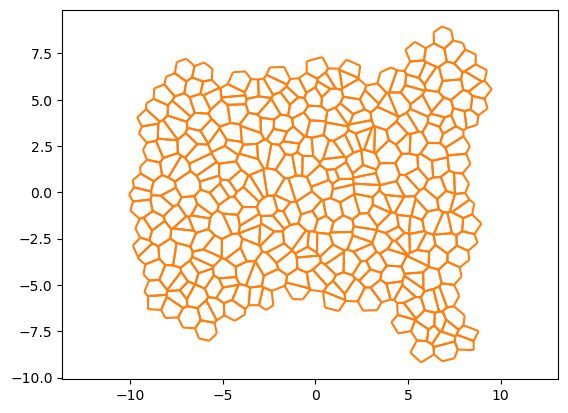

In [ ]:
meshes_sat_true[35].cellplot(edge_colors={key: "tab:orange" for key in mesh_initial.hes.keys()})

plt.axis("equal")

[<matplotlib.lines.Line2D>]

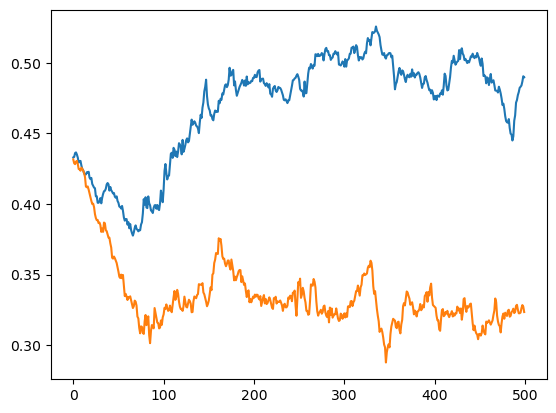

In [ ]:
plt.plot(np.median(ltc_series_true[:,0], axis=-1)/np.pi)
plt.plot(np.median(ltc_series_sat_true[:,0], axis=-1)/np.pi)

# if we increase the passive tension relaxation for True, we also see a bigger effect of the single-triangle dynamics

<matplotlib.legend.Legend>

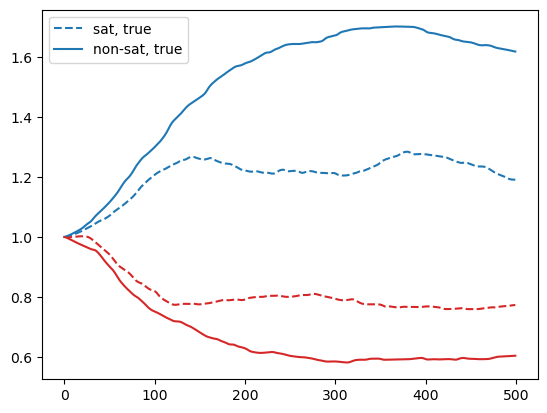

In [ ]:
plt.plot(np.exp(delta_series_sat_true[:,0]), color="tab:blue", ls="dashed", label="sat, true")
plt.plot(np.exp(delta_series_sat_true[:,1]), color="tab:red", ls="dashed")


plt.plot(np.exp(delta_series_true[:,0]), color="tab:blue", label="non-sat, true")
plt.plot(np.exp(delta_series_true[:,1]), color="tab:red")

plt.legend()

Text(0, 0.5, 'T1 rate')

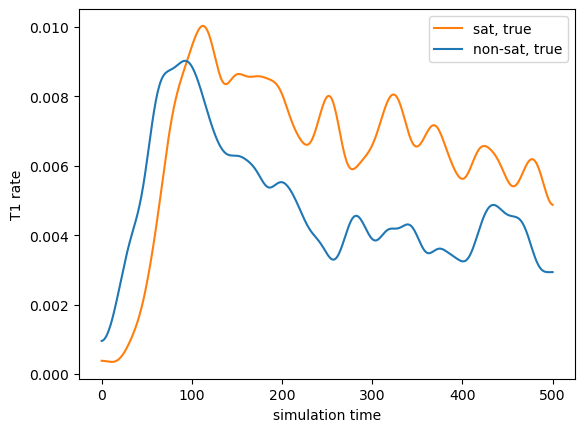

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate_sat_true, sigma=10), color="tab:orange", label="sat, true")
plt.plot(ndimage.gaussian_filter1d(T1_rate_true, sigma=10), color="tab:blue", label="non-sat, true")

plt.legend()

plt.xlabel("simulation time")
plt.ylabel("T1 rate")

# only relatively weak difference in T1 rate

In [ ]:
# aspect ratio change: 2.2 with (T-Tp) for T_+ = 4.  3.6 without!! AKA elongation by 50% and 90% resp.
# Much better ?? Still saturates.
# probably the reason is that the anisotropy is not dissipated rapidly. However, in this case it is not completely clear whether 
# new junctions can still extend without 

# clean version of lattice simulation confirms that on the single-kite level, new junctions can extend without the T-T_p prescription

# this makes sense. The post-T1 behavior defines how rapdily T1s destroy the initial tension anisotropy.
# if they are destroyed rapidly, this means faster arrest.

# If, otoh, you use the T-T_p prescription, this gives tension dynamics post the first T1 a strong boost to decrease tension on the new junction
# this boost effaces the difference between different autonomous tension dynamics laws

In [ ]:
np.sqrt(2.2), np.sqrt(3.5)

(1.4832396974191326, 1.8708286933869707)

Text(0, 0.5, 'sqrt(Aspect ratio change)')

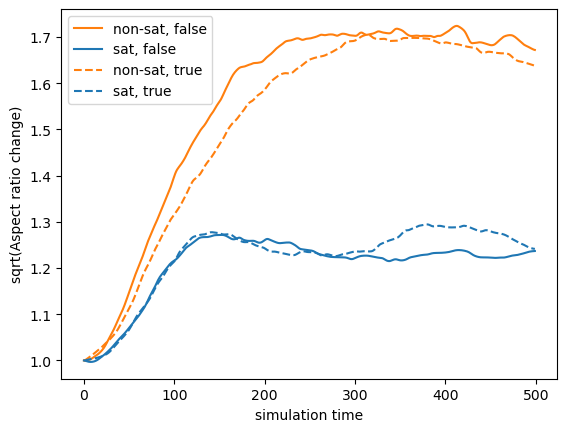

In [ ]:
plt.plot(elongation, color="tab:orange", label="non-sat, false")
plt.plot(elongation_sat, color="tab:blue", label="sat, false")


plt.plot(elongation_true, color="tab:orange", label="non-sat, true", ls="dashed")
plt.plot(elongation_sat_true, color="tab:blue", label="sat, true", ls="dashed")


plt.legend()

plt.xlabel("simulation time")
plt.ylabel("sqrt(Aspect ratio change)")

# difference in elongation-differences still there, but much weaker than for a smaller sample

(0.0, 2.5)

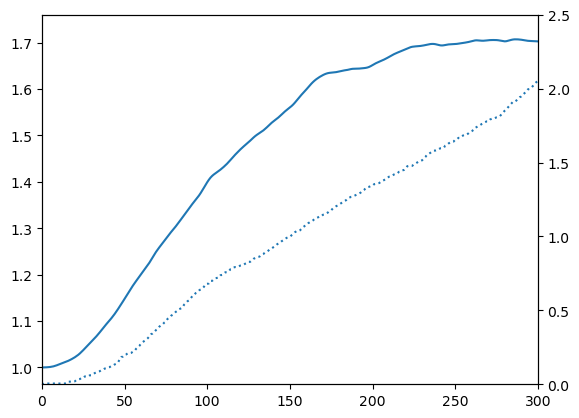

In [ ]:
plt.plot(elongation, color="tab:blue")

plt.gca().twinx().plot(np.cumsum(T1_rate), color="tab:blue", ls="dotted") # saturation at ca 350. about 2 T1s/cell. without T-Tp

plt.xlim([0, 300])
plt.ylim([0, 2.5])

## Comparison of T_p vs npn-T_P post T1 transcription and interaction with disorder

In [ ]:
mesh_initial_order, property_dict_order = ecm.create_hard_disk_initial(24, 18, eta=0.85, noise_gaussian=0.075, initial_strain=0.085, # 0.125
                                                                       remove_boundary_dx=0.75, n_chains=50, chain_time=100, progress_bar=True,)

passive_ids_order = property_dict_order['passive_faces']
passive_cells_order = property_dict_order['passive_cells']

  0%|          | 0/50 [00:00<?, ?it/s]

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/ecmc.py:190: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


KeyboardInterrupt: 

In [ ]:
mesh_initial_disorder, property_dict_disorder = ecm.create_hard_disk_initial(24, 18, eta=0.45, noise_gaussian=0.075, initial_strain=0.1, #.125
                                                                             remove_boundary_dx=0.75, n_chains=300, chain_time=200,
                                                                             progress_bar=True,)

passive_ids_disorder = property_dict_disorder['passive_faces']
passive_cells_disorder = property_dict_disorder['passive_cells']

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
ecm.get_valences(mesh_initial_disorder)

{4: 0.018, 5: 0.246, 6: 0.526, 7: 0.175, 8: 0.035}

In [ ]:
mesh_initial_mid, property_dict_mid = ecm.create_hard_disk_initial(24, 18, eta=0.7, noise_gaussian=0.075, initial_strain=0.1, #.125
                                                                             remove_boundary_dx=0.75, n_chains=300, chain_time=200,
                                                                             progress_bar=True,) # eta = 0.7. 0.6 would seem too low

passive_ids_mid = property_dict_mid['passive_faces']
passive_cells_mid = property_dict_mid['passive_cells']

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
ecm.get_valences(mesh_initial_mid)

In [ ]:
np.round(100*(np.array(list(mesh_initial_disorder.get_primal_edge_lens().values())) < 0).mean())

# 6% below voronoi limit for 0.1
# 5% for 0.125 ??

In [ ]:
ana.get_anisos_S(mesh_initial_disorder)[0], ana.get_anisos_S(mesh_initial_order)[0]

In [ ]:
mesh_initial_order.triplot()

plt.axis("equal")

In [ ]:
mesh_initial_mid.triplot()

plt.axis("equal")

In [ ]:
mesh_initial_disorder.triplot()

plt.axis("equal")

In [ ]:
dt = .005 # time step
n_steps = 500
forbid_reflip = 20

minimal_l = 0.0 # minimal edge length, lower edge lengths trigger T1
tri_mod_area = .01 # triangle area regularization

In [ ]:
## simulation loop - define as function to use joblib later.

def run_simulation(subtract_passive, eta, k=0.5, n_steps=n_steps, dt=dt, forbid_reflip=forbid_reflip, keep_in_memory=False,
                   log_rate=20, verbose=False):
    """Local function to run simulation. To save memory, keeping all meshes in RAM is optional."""
    
    # initialize the relevant quantities for the measurement
    ltc_series= []
    valence_series= []
    delta_series = []
    
    # select initial condition
    if eta == 0.85:
        mesh = deepcopy(mesh_initial_order)
        passive_ids = passive_ids_order
        passive_cells = passive_cells_order
    elif eta == 0.45:
        mesh = deepcopy(mesh_initial_disorder)
        passive_ids = passive_ids_disorder
        passive_cells = passive_cells_disorder

    # define the feedback parameters
    def params_pattern(fid):
        if fid in passive_ids:
            return {"m": None, "k_cutoff": None, "k": 4*k, "is_active": False, "subtract_passive": subtract_passive} 
        return {"m": 4, "k_cutoff": 0.2, "k": k, "is_active": True, "subtract_passive": subtract_passive} 

    # set up simulation loop
    times = [0]
    last_flipped_edges = [[]]
    mesh_previous = deepcopy(mesh)
    if keep_in_memory:
        meshes = [mesh_previous]
    else:
        meshes = [mesh_previous]
    
    mesh = deepcopy(meshes[-1])
    for i in tqdm(range(n_steps)):
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=None)
        # flatten triangulation
        sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, reset_intrinsic=True, return_sol=True)
        if sol["status"] != 0:
            break
            
        # set voronoi positions
        mesh.set_voronoi()
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False, optimizer_args=None)
        if verbose:
            if failed_flip:
                print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
            if flipped and not failed_flip:
                print(f"tpt {i}: flip {flipped}")
        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        if keep_in_memory:
            meshes.append(mesh_previous)
        if not keep_in_memory and ((i%log_rate) == 0) and (i > 0): # if I am not storing all meshes
            meshes.append(mesh_previous)
        # make measurements
        valence_series.append(ecm.get_valences(mesh))
        ltc_dist = tns.angles_shape(np.array(list(mesh.get_vertex_angles(exclude=None, method="dual").values())).T)
        ltc_series.append(ltc_dist)
        delta_series.append(get_width_height(mesh))
    # post-processing
    last_flipped_edges.append([])
    T1_rate = np.array([len(x) for x in last_flipped_edges[1:]]) / len(meshes[0].vertices)  # dt!! - should not use that. just use raw t1s.
    ltc_series = np.stack(ltc_series)
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    return subtract_passive, eta, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series    

In [ ]:
%%time

# run a single simulation
data = run_simulation(subtract_passive=True, eta=0.85, k=0.5, n_steps=10, keep_in_memory=True, verbose=True)
_, _, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series = data

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1.28 s, sys: 14.2 ms, total: 1.3 s
Wall time: 1.29 s


In [ ]:
subtract_passives = [False,] # True
etas = [0.85,]
to_do = list(itertools.product(subtract_passives, etas))

In [ ]:
meshes_dict = {}
T1_rate_dict  = {}
last_flip_dict = {}
ltc_dict  = {}
valence_dict = {}
delta_dict  = {}

for subtract_passive, eta in tqdm(to_do):
    data = run_simulation(subtract_passive=subtract_passive, eta=eta, k=4, # 1
                          n_steps=750, dt=0.005, forbid_reflip=20, keep_in_memory=True, verbose=False)

    _, _, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series = data
    meshes_dict[(subtract_passive, eta)] = meshes
    last_flip_dict[(subtract_passive, eta)] = last_flipped_edges
    T1_rate_dict[(subtract_passive, eta)]  = T1_rate
    ltc_dict[(subtract_passive, eta)]  = ltc_series
    valence_dict[(subtract_passive, eta)] = valence_series
    delta_dict[(subtract_passive, eta)]  = delta_series

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
delta_dict.keys()

dict_keys([(False, 0.85), (True, 0.85)])

In [ ]:
aniso_dict = {key: np.array([ana.get_anisos_S(x)[0] for x in val]) for key, val in meshes_dict.items()}

In [ ]:
for (subtract_passive, eta), meshes in meshes_dict.items():
    #delta_series = delta_dict[(subtract_passive, eta)] = ana.get_delta_centerline(meshes, sigma=1)[0]
    # this does not work super well for these small guys
    
    delta_series = np.stack([get_width_height_tri(x, q=0.8) for x in meshes])
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    delta_dict[(subtract_passive, eta)] = delta_series

elongation_dict = {key: np.sqrt(np.exp(val[:,0])/np.exp(val[:,1])) for key, val in delta_dict.items()}

In [ ]:
time = np.arange(elongation_dict[(False, 0.85)].shape[0]) * 25 * 0.005  

Text(0.5, 1.025, 'Post-T1 prescription vs elongation, Voronoi')

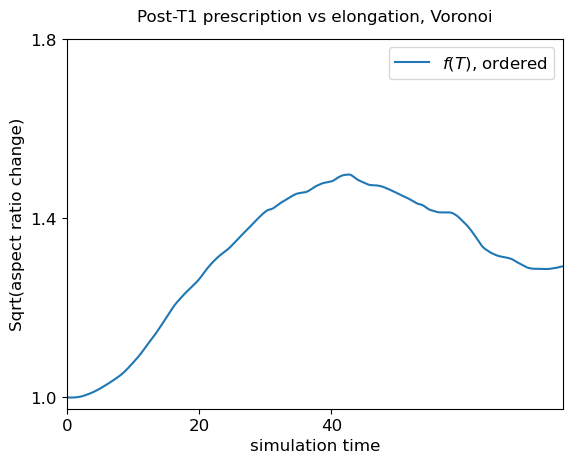

In [ ]:
#plt.plot(time, elongation_dict[(True, 0.85)], color="tab:blue", ls="dashed", label=r"$f(T-T_p)$, ordered")
plt.plot(time, elongation_dict[(False, 0.85)], color="tab:blue", label=r"$f(T)$, ordered")

#plt.plot(time, elongation_dict[(True, 0.45)], color="tab:orange", ls="dashed", label=r"$f(T-T_p)$, disordered",)
#plt.plot(time, elongation_dict[(False, 0.45)], color="tab:orange", label=r"$f(T)$, disordered",)

plt.xlim([0, 75])

plt.legend(fontsize=12)
plt.xlabel("simulation time", fontsize=12)
plt.ylabel("Sqrt(aspect ratio change)", fontsize=12)

plt.xticks([0, 20, 40], fontsize=12)
plt.yticks([1, 1.4, 1.8], fontsize=12)

plt.title("Post-T1 prescription vs elongation, Voronoi", y=1.025)


In [ ]:
elongation_dict[(False, 0.85)][400] # 1.6 1st iteration. 2nd iteration 1.46. Might really be somewhat random!!!
# Do I need bigger meshes? Or more samples

1.455692454688016

In [ ]:
bdry_x, bdry_y = (9, 9)

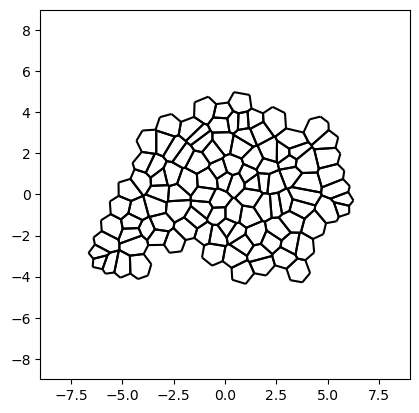

In [ ]:
meshes_dict[(False, 0.85)][550].cellplot()

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

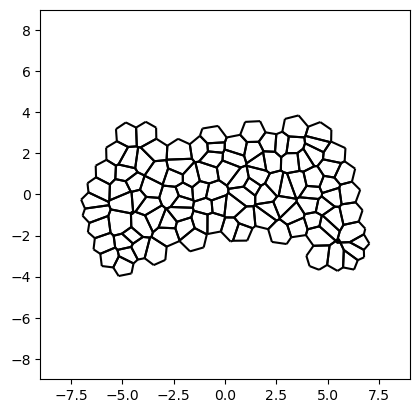

In [ ]:
meshes_dict[(False, 0.85)][550].cellplot()

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

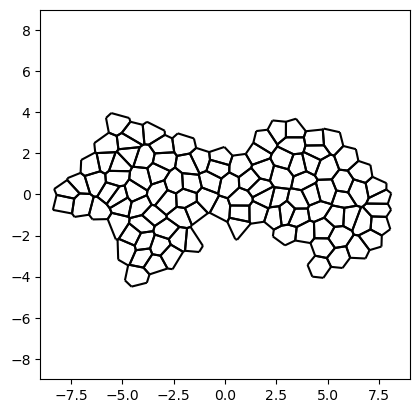

In [ ]:
meshes_dict[(False, 0.85)][550].cellplot()

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

Text(0, 0.5, 'Median shape angle')

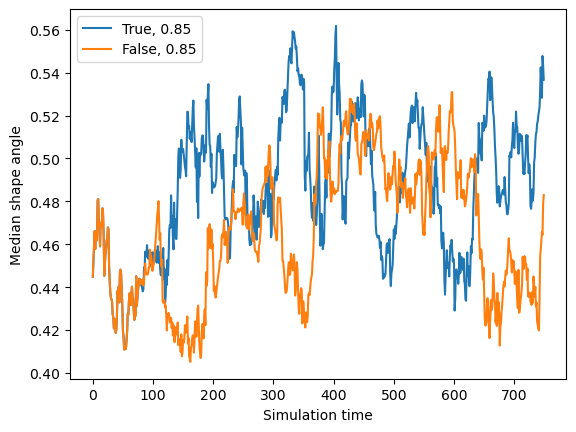

In [ ]:
plt.plot(np.median(ltc_dict[(True, 0.85)], axis=-1)[:,0] / np.pi, color="tab:blue", label="True, 0.85")
plt.plot(np.median(ltc_dict[(False, 0.85)], axis=-1)[:,0] / np.pi, color="tab:orange", label="False, 0.85")


#plt.plot(np.median(ltc_dict[(True, 0.45)], axis=-1)[:,0] / np.pi, color="tab:blue", ls="dashed", label="True, 0.45")
#plt.plot(np.median(ltc_dict[(False, 0.45)], axis=-1)[:,0] / np.pi, color="tab:orange", ls="dashed", label="False, 0.45")
# those two are v similar

plt.legend()
plt.xlabel("Simulation time")
plt.ylabel("Median shape angle")

Text(0, 0.5, 'Median anisotropy')

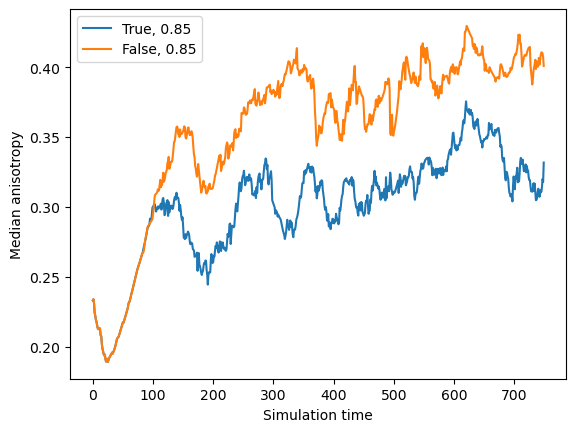

In [ ]:
plt.plot(np.median(ltc_dict[(True, 0.85)], axis=-1)[:,1], color="tab:blue", label="True, 0.85")
plt.plot(np.median(ltc_dict[(False, 0.85)], axis=-1)[:,1], color="tab:orange", label="False, 0.85")

plt.legend()
plt.xlabel("Simulation time")
plt.ylabel("Median anisotropy")

Text(0.5, 1.025, 'Post-T1 prescription vs elongation, Voronoi')

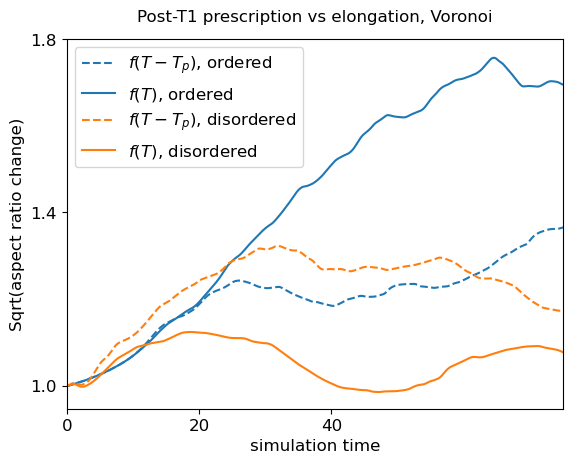

In [ ]:
plt.plot(time, elongation_dict[(True, 0.85)], color="tab:blue", ls="dashed", label=r"$f(T-T_p)$, ordered")
plt.plot(time, elongation_dict[(False, 0.85)], color="tab:blue", label=r"$f(T)$, ordered")

plt.plot(time, elongation_dict[(True, 0.45)], color="tab:orange", ls="dashed", label=r"$f(T-T_p)$, disordered",)
plt.plot(time, elongation_dict[(False, 0.45)], color="tab:orange", label=r"$f(T)$, disordered",)

plt.xlim([0, 75])

plt.legend(fontsize=12)
plt.xlabel("simulation time", fontsize=12)
plt.ylabel("Sqrt(aspect ratio change)", fontsize=12)

plt.xticks([0, 20, 40], fontsize=12)
plt.yticks([1, 1.4, 1.8], fontsize=12)

plt.title("Post-T1 prescription vs elongation, Voronoi", y=1.025)

# needs longer now to arrest flow.

With ``initial_strain=0.125``

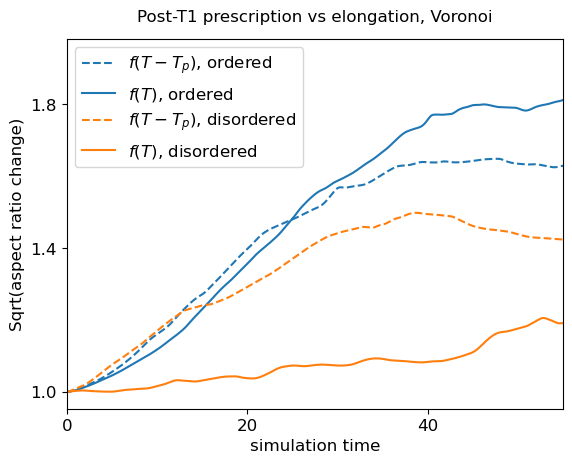

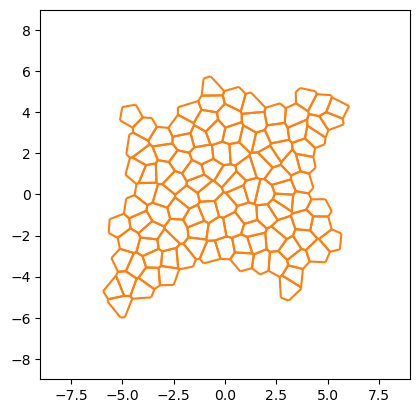

In [ ]:
meshes_dict[(False, 0.45)][350].cellplot(edge_colors={key: "tab:orange" for key in meshes_dict[(False, 0.45)][450].hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

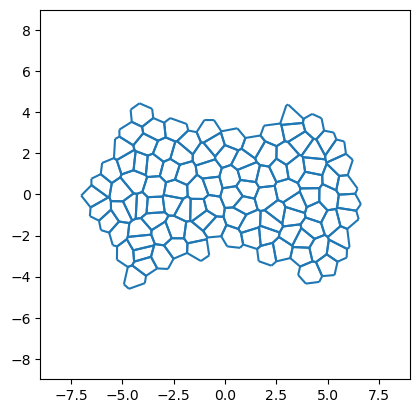

In [ ]:
meshes_dict[(False, 0.85)][350].cellplot(edge_colors={key: "tab:blue" for key in meshes_dict[(False, 0.85)][450].hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

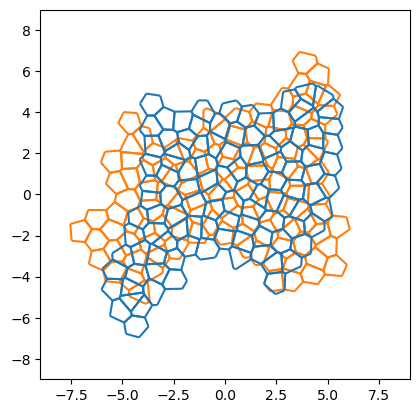

In [ ]:
meshes_dict[(True, 0.45)][400].cellplot(edge_colors={key: "tab:orange" for key in meshes_dict[(False, 0.45)][450].hes.keys()})
meshes_dict[(True, 0.85)][400].cellplot(edge_colors={key: "tab:blue" for key in meshes_dict[(False, 0.85)][450].hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

([<matplotlib.axis.YTick>,
  <matplotlib.axis.YTick>,
  <matplotlib.axis.YTick>,
  <matplotlib.axis.YTick>],
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.3, '0.3')])

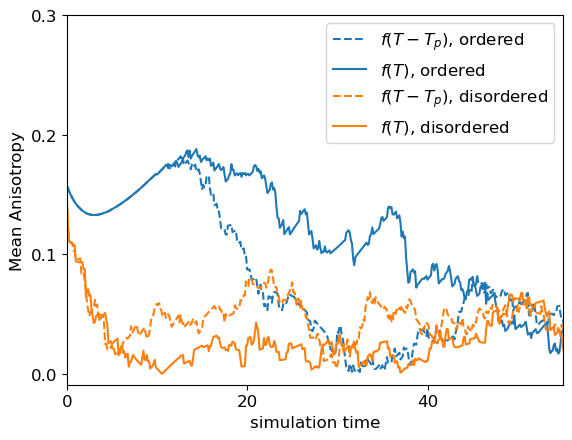

In [ ]:
plt.plot(time, aniso_dict[(True, 0.85)], color="tab:blue", ls="dashed", label=r"$f(T-T_p)$, ordered")
plt.plot(time, aniso_dict[(False, 0.85)], color="tab:blue", label=r"$f(T)$, ordered")

plt.plot(time, aniso_dict[(True, 0.45)], color="tab:orange", ls="dashed", label=r"$f(T-T_p)$, disordered",)
plt.plot(time, aniso_dict[(False, 0.45)], color="tab:orange", label=r"$f(T)$, disordered",)

plt.xlim([0, 55])

plt.legend(fontsize=12)
plt.xlabel("simulation time", fontsize=12)
plt.ylabel("Mean Anisotropy", fontsize=12)

plt.xticks([0, 20, 40], fontsize=12)
plt.yticks([0., 0.1, 0.2, 0.3], fontsize=12)

#plt.title("Post-T1 prescription vs elongation, Voronoi", y=1.025)

(0.0, 80.0)

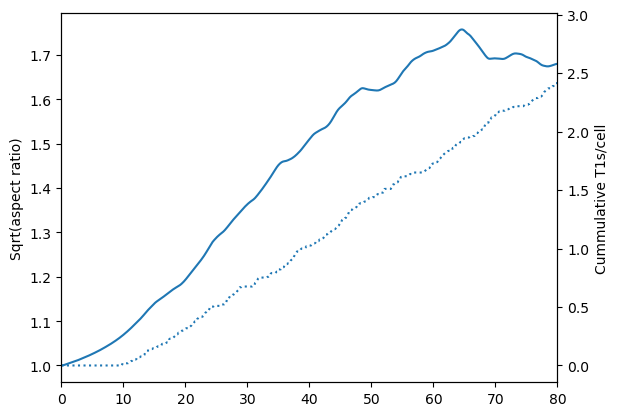

In [ ]:
plt.plot(time, elongation_dict[(False, 0.85)], color="tab:blue")

plt.ylabel("Sqrt(aspect ratio)")

plt.gca().twinx().plot(time, np.cumsum(T1_rate_dict[(False, 0.85)]), color="tab:blue", ls="dotted")
plt.ylabel("Cummulative T1s/cell")

plt.xlabel("time")
plt.xlim([0, 80])

# saturation at ca 60 mins. about 2 T1s/cell. and elongation of 1.8x.

In [ ]:
elongation_dict[(False, 0.85)].max()

1.7568887404374383

In [ ]:
T1_rate_dict[(True, 0.85)]

## Non-Voronoi simulations, influence of post-T1 prescription

In [ ]:
dt = .005 # time step
n_steps = 500
forbid_reflip = 20

minimal_l = 0.06 # minimal edge length, lower edge lengths trigger T1
tri_mod_area = .01 # triangle area regularization

In [ ]:
# elastic energy parameters

tol, maxiter = (1e-4, 50000)
mod_bulk = 1
mod_shear = 1
angle_penalty = 1000
bdry_penalty = 0

epsilon_l = (1e-3, 1e-3)  # mollifying parameters to ensure energy differentiability
mod_area = 0; mod_perimeter = 0 # no area-perimeter elasticity

bdr_weight = 1 # avoid problems at boundary
rel_elastic_modulus = 0

def rhs_rest_shape(v): # no rest shape relaxation, since we have no passive cells
    return 0

# package all into a single dict to pass to the optimizer method
energy_args = {'mod_bulk': mod_bulk, 'mod_shear': mod_shear,
               'angle_penalty': angle_penalty, 'bdry_penalty': bdry_penalty, 'epsilon_l': epsilon_l,
               'mod_area': mod_area, 'mod_perimeter': mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## simulation loop - define as function to use joblib later.

def run_simulation_elastic(subtract_passive, eta, k=0.5, n_steps=n_steps, dt=dt, forbid_reflip=forbid_reflip, keep_in_memory=False,
                           log_rate=20, verbose=False):
    """Local function to run simulation. To save memory, keeping all meshes in RAM is optional."""
    
    # initialize the relevant quantities for the measurement
    ltc_series= []
    valence_series= []
    delta_series = []
    
    # select initial condition
    if eta == 0.85:
        mesh = deepcopy(mesh_initial_order)
        passive_ids = passive_ids_order
        passive_cells = passive_cells_order
    elif eta == 0.45:
        mesh = deepcopy(mesh_initial_disorder)
        passive_ids = passive_ids_disorder
        passive_cells = passive_cells_disorder

    # define the feedback parameters
    def params_pattern(fid):
        if fid in passive_ids:
            return {"m": None, "k_cutoff": None, "k": 4*k, "is_active": False, "subtract_passive": subtract_passive} 
        return {"m": 4, "k_cutoff": 0.2, "k": k, "is_active": True, "subtract_passive": subtract_passive} 

    # make passive cells soft
    cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))
    optimizer_args['cell_id_to_modulus'] = cell_id_to_modulus
    
    # set up simulation loop
    times = [0]
    last_flipped_edges = [[]]
    mesh_previous = deepcopy(mesh)
    if keep_in_memory:
        meshes = [mesh_previous]
    else:
        meshes = [mesh_previous]
    
    mesh = deepcopy(meshes[-1])
    for i in tqdm(range(n_steps)):
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=None)
        # flatten triangulation
        sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, reset_intrinsic=True, return_sol=True)
        if sol["status"] != 0:
            break
        # elastic energy minimization
        sol = mesh.optimize_cell_shape(**optimizer_args, return_sol=True)
        if sol["status"] !=0 and (sol["message"] == "NaN result encountered."):
            break
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False, optimizer_args=None)
        if verbose:
            if failed_flip:
                print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
            if flipped and not failed_flip:
                print(f"tpt {i}: flip {flipped}")
        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        if keep_in_memory:
            meshes.append(mesh_previous)
        if not keep_in_memory and ((i%log_rate) == 0) and (i > 0): # if I am not storing all meshes
            meshes.append(mesh_previous)
        # make measurements
        valence_series.append(ecm.get_valences(mesh))
        ltc_dist = tns.angles_shape(np.array(list(mesh.get_vertex_angles(exclude=None, method="dual").values())).T)
        ltc_series.append(ltc_dist)
        delta_series.append(get_width_height(mesh))
    # post-processing
    last_flipped_edges.append([])
    T1_rate = np.array([len(x) for x in last_flipped_edges[1:]]) / len(meshes[0].vertices)  # dt!! - should not use that. just use raw t1s.
    ltc_series = np.stack(ltc_series)
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    return subtract_passive, eta, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series    

In [ ]:
%%time

# run a single simulation
data = run_simulation_elastic(subtract_passive=True, eta=0.85, k=1, n_steps=10, keep_in_memory=True, verbose=True)
_, _, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series = data

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2.03 s, sys: 6.7 ms, total: 2.04 s
Wall time: 2.03 s


In [ ]:
subtract_passives = [True, False]
etas = [0.45, 0.85]
to_do = list(itertools.product(subtract_passives, etas))

In [ ]:
meshes_dict = {}
T1_rate_dict  = {}
last_flip_dict = {}
ltc_dict  = {}
valence_dict = {}
delta_dict  = {}

In [ ]:
# maybe use k=2, and lower initial tension say 0.1

In [ ]:
for subtract_passive, eta in tqdm(to_do[:2]):
    data = run_simulation_elastic(subtract_passive=subtract_passive, eta=eta, k=1,
                                  n_steps=600, dt=0.005, forbid_reflip=20, keep_in_memory=True, verbose=False)

    _, _, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series = data
    meshes_dict[(subtract_passive, eta)] = meshes
    last_flip_dict[(subtract_passive, eta)] = last_flipped_edges
    T1_rate_dict[(subtract_passive, eta)]  = T1_rate
    ltc_dict[(subtract_passive, eta)]  = ltc_series
    valence_dict[(subtract_passive, eta)] = valence_series
    delta_dict[(subtract_passive, eta)]  = delta_series
    
# 7 min per simulation. maybe make initial cond more dependent 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
delta_dict.keys()

dict_keys([(False, 0.45), (False, 0.85), (True, 0.45), (True, 0.85)])

In [ ]:
time = np.arange(elongation_dict[(True, 0.85)].shape[0]) * 25 * 0.005  

In [ ]:
aniso_dict = {key: np.array([ana.get_anisos_S(x)[0] for x in val]) for key, val in meshes_dict.items()}

In [ ]:
for (subtract_passive, eta), meshes in meshes_dict.items():
    #delta_series = delta_dict[(subtract_passive, eta)] = ana.get_delta_centerline(meshes, sigma=1)[0]
    # this does not work super well for these small guys
    
    delta_series = np.stack([get_width_height_tri(x, q=0.8) for x in meshes])
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    delta_dict[(subtract_passive, eta)] = delta_series

elongation_dict = {key: np.sqrt(np.exp(val[:,0])/np.exp(val[:,1])) for key, val in delta_dict.items()}

In [ ]:
bdry_x, bdry_y = (10, 10)

In [ ]:
time[400]

50.0

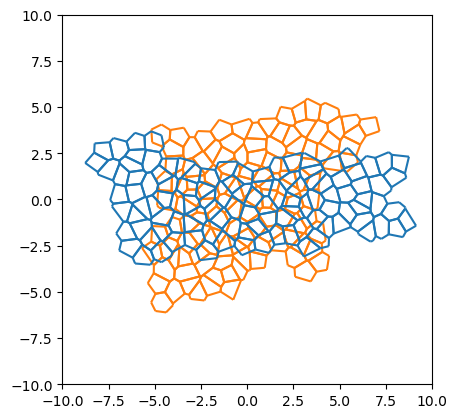

In [ ]:
meshes_dict[(False, 0.45)][400].cellplot(edge_colors={key: "tab:orange" for key in meshes_dict[(False, 0.45)][450].hes.keys()})
meshes_dict[(False, 0.85)][400].cellplot(edge_colors={key: "tab:blue" for key in meshes_dict[(False, 0.85)][450].hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

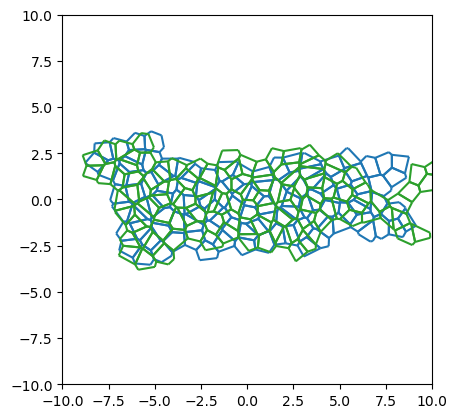

In [ ]:
meshes_dict[(False, 0.85)][400].cellplot(edge_colors={key: "tab:blue" for key in meshes_dict[(False, 0.85)][450].hes.keys()})

meshes_dict[(False, 0.85)][500].cellplot(edge_colors={key: "tab:green" for key in meshes_dict[(False, 0.85)][450].hes.keys()})


ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

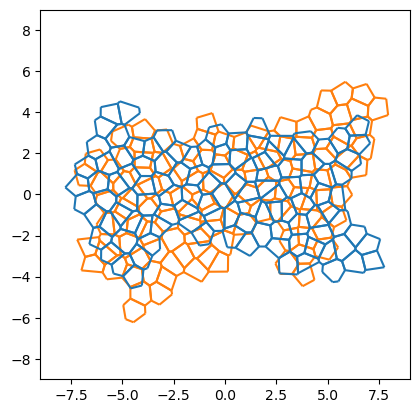

In [ ]:
meshes_dict[(True, 0.45)][400].cellplot(edge_colors={key: "tab:orange" for key in meshes_dict[(False, 0.45)][450].hes.keys()})
meshes_dict[(True, 0.85)][400].cellplot(edge_colors={key: "tab:blue" for key in meshes_dict[(False, 0.85)][450].hes.keys()})

ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

Text(0.5, 1.025, 'Post-T1 prescription vs elongation, elastic energy')

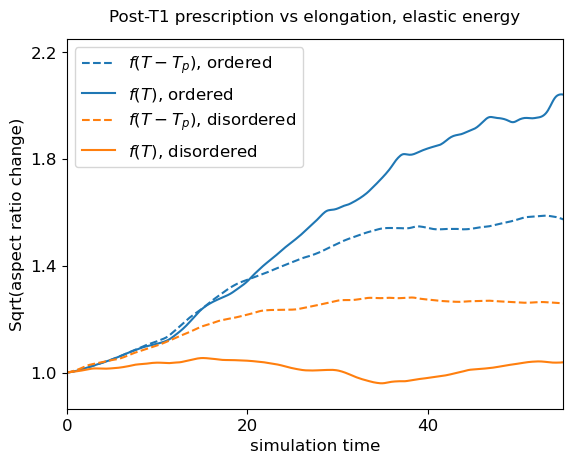

In [ ]:
plt.plot(time, elongation_dict[(True, 0.85)], color="tab:blue", ls="dashed", label=r"$f(T-T_p)$, ordered")
plt.plot(time, elongation_dict[(False, 0.85)], color="tab:blue", label=r"$f(T)$, ordered")

plt.plot(time, elongation_dict[(True, 0.45)], color="tab:orange", ls="dashed", label=r"$f(T-T_p)$, disordered",)
plt.plot(time, elongation_dict[(False, 0.45)], color="tab:orange", label=r"$f(T)$, disordered",)

plt.xlim([0, 55])

plt.legend(fontsize=12)
plt.xlabel("simulation time", fontsize=12)
plt.ylabel("Sqrt(aspect ratio change)", fontsize=12)

plt.xticks([0, 20, 40], fontsize=12)
plt.yticks([1, 1.4, 1.8, 2.2], fontsize=12)

plt.title("Post-T1 prescription vs elongation, elastic energy", y=1.025)

([<matplotlib.axis.YTick>,
  <matplotlib.axis.YTick>,
  <matplotlib.axis.YTick>,
  <matplotlib.axis.YTick>],
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.3, '0.3')])

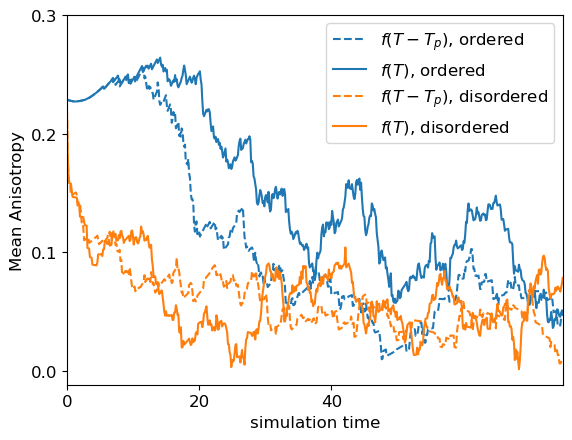

In [ ]:
plt.plot(time, aniso_dict[(True, 0.85)], color="tab:blue", ls="dashed", label=r"$f(T-T_p)$, ordered")
plt.plot(time, aniso_dict[(False, 0.85)], color="tab:blue", label=r"$f(T)$, ordered")

plt.plot(time, aniso_dict[(True, 0.45)], color="tab:orange", ls="dashed", label=r"$f(T-T_p)$, disordered",)
plt.plot(time, aniso_dict[(False, 0.45)], color="tab:orange", label=r"$f(T)$, disordered",)

plt.xlim([0, 75])

plt.legend(fontsize=12)
plt.xlabel("simulation time", fontsize=12)
plt.ylabel("Mean Anisotropy", fontsize=12)

plt.xticks([0, 20, 40], fontsize=12)
plt.yticks([0., 0.1, 0.2, 0.3], fontsize=12)


In [ ]:
aniso_dict[(False, 0.45)][:4], 0.23 - 0.152

(array([0.23015251, 0.18312872, 0.16495052, 0.15810587]), 0.07800000000000001)

(0.0, 80.0)

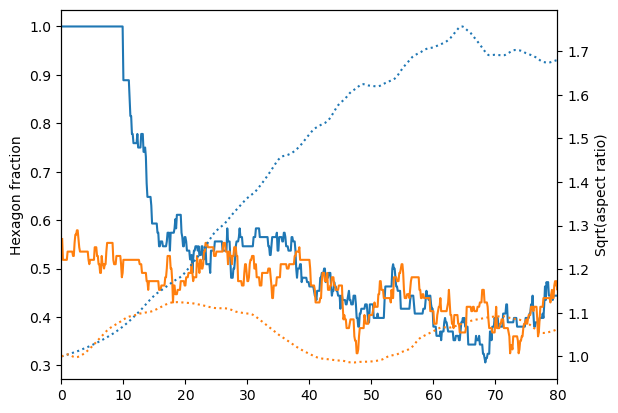

In [ ]:
plt.plot(time[1:], [x[6] for x in valence_dict[(False, 0.85)]], color="tab:blue")
plt.plot(time[1:], [x[6] for x in valence_dict[(False, 0.45)]], color="tab:orange")

# inflection point in anisotropy approx. where hexagon fraction reaches the random limit. (20 mins)
# hexagon fraction vs time not too different between True and False

plt.ylabel("Hexagon fraction")

ax2 = plt.gca().twinx()
ax2.plot(time, elongation_dict[(False, 0.85)], color="tab:blue", ls="dotted")
ax2.plot(time, elongation_dict[(False, 0.45)], color="tab:orange", ls="dotted")

plt.ylabel("Sqrt(aspect ratio)")

plt.xlabel("time")
plt.xlim([0, 80])


(0.0, 80.0)

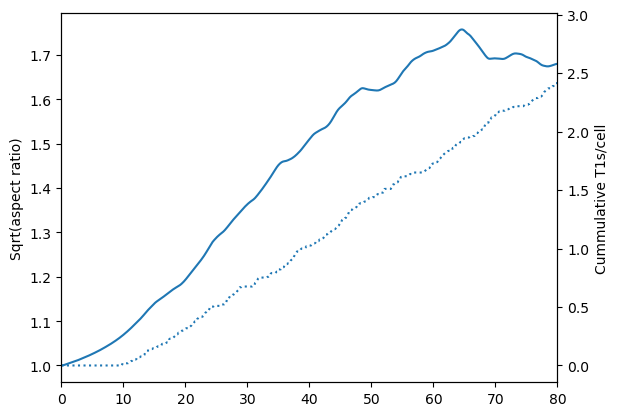

In [ ]:
plt.plot(time, elongation_dict[(False, 0.85)], color="tab:blue")

plt.ylabel("Sqrt(aspect ratio)")

plt.gca().twinx().plot(time, np.cumsum(T1_rate_dict[(False, 0.85)]), color="tab:blue", ls="dotted")
plt.ylabel("Cummulative T1s/cell")

plt.xlabel("time")
plt.xlim([0, 80])


Text(0, 0.5, 'Median shape angle')

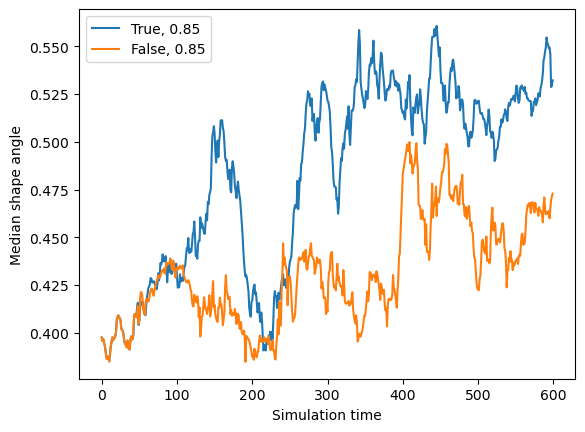

In [ ]:
plt.plot(np.median(ltc_dict[(True, 0.85)], axis=-1)[:,0] / np.pi, color="tab:blue", label="True, 0.85")
plt.plot(np.median(ltc_dict[(False, 0.85)], axis=-1)[:,0] / np.pi, color="tab:orange", label="False, 0.85")


#plt.plot(np.median(ltc_dict[(True, 0.45)], axis=-1)[:,0] / np.pi, color="tab:blue", ls="dashed", label="True, 0.45")
#plt.plot(np.median(ltc_dict[(False, 0.45)], axis=-1)[:,0] / np.pi, color="tab:orange", ls="dashed", label="False, 0.45")
# those two are v similar

plt.legend()
plt.xlabel("Simulation time")
plt.ylabel("Median shape angle")

## Tanh - feedback

In [ ]:
def tanh_dt(Ts, T_c=1, scale=1):
    f_T = jnp.tanh(scale*(Ts/(T_c*jnp.mean(Ts))-1))
    return f_T - jnp.sum(f_T)/3


In [ ]:
# define saturating feedback function

def tanh_dt_act_pass(Ts: NDArray[Shape["3"], Float], Tps: NDArray[Shape["3"], Float],
                     T_c=1, scale=1, k=1, is_active=True
                    ) -> Tuple[NDArray[Shape["3"],Float],NDArray[Shape["3"],Float]]:
    """
    Time derivative of tensions under tanh positive feedback model, including passive tension.
    
    Parameters
    ----------
    Ts : (3,) array
        active tensions
    Tps : (3,) array
        passive tensions
    T_c: float
        Fixed point of tension feedback
    scale: float
        saturation of tanh
    k : float
        passive tension relaxation rate
    is_active : bool
        Whether the given triangle is active. Otherwise, relax to 1.
        
    Returns
    -------
    dT_dt : (3,) array
        time derivative of active tension
    dTp_dt : (3,) array
        time derivative of passive tension

    """
    if is_active:
        #Ts_eff = Ts-Tps
        #dT_dt = jnp.tanh(scale*(Ts_eff/(T_c*jnp.mean(Ts_eff))-1)) - k*Tps
        dT_dt = jnp.tanh(scale*(Ts/(T_c*jnp.mean(Ts))-1)) - k*Tps
        #dT_dt = jnp.tanh(scale*(Ts/T_c-1)) - k*Tps
        dTp_dt = -k*Tps
        dT_dt -= dT_dt.mean()
    else:
        dT_dt = -k*(Ts-1)
        dTp_dt = np.zeros(3)
        dT_dt -= dT_dt.mean()
    return dT_dt, dTp_dt

In [ ]:
## Set parameters

dt = .05 # time step
n_steps = 500

minimal_l = 0.0 # minimal edge length, lower edge lengths trigger T1
tri_mod_area = .01 # triangle area regularization

In [ ]:
mesh_initial, property_dict= drs.create_rect_initial(18, 22, noise=0.1, initial_strain=0.1, # .125
                                                     orientation='orthogonal', isogonal=0,
                                                     boundaries=None, w_passive=0, w_passive_lr=0,
                                                     random_seed=15) # 3

passive_ids = property_dict['passive_faces']
passive_cells = property_dict['passive_cells']


(-8.904277707128688, 8.90986484871722, -10.752447250096024, 10.747552749903974)

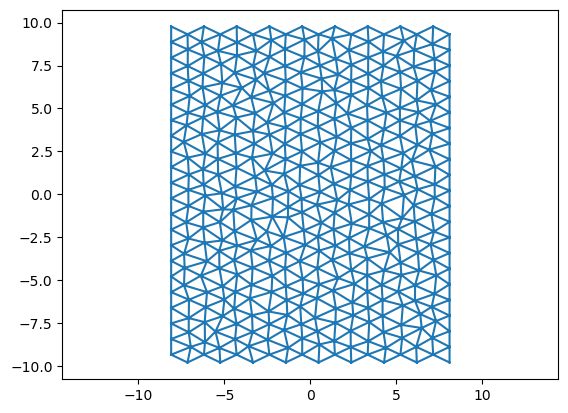

In [ ]:
mesh_initial.triplot()
plt.axis("equal")

In [ ]:
dT = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0, T_c=1, T_plus=4))
                for fc in mesh_initial.faces.values()])
dT_tanh = np.median([np.linalg.norm(tanh_dt(np.array([he.rest for he in fc.hes]), T_c=1.2, scale=5))
                for fc in mesh_initial.faces.values()])


dT, dT_tanh, dT/dT_tanh

(0.5103654667301657, 0.3742588152692344, 1.363669861357892)

In [ ]:
## simulation loop - define as function to use joblib later.


def run_simulation_tanh(T_c, scale, k_relax=2, k=0.5, n_steps=n_steps, dt=dt, forbid_reflip=50,
                        keep_in_memory=False, log_rate=20, verbose=False):
    """Local function to run simulation. To save memory, keeping all meshes in RAM is optional."""
    # define the feedback parameters
    
    
    def params_pattern(fid):
        if fid in passive_ids:
            return {"T_c": T_c, "scale": scale, "k": 4*k, "is_active": False} 
        return {"T_c": T_c, "scale": scale, "k": k, "is_active": True} 
    
    # initialize the relevant quantities for the measurement
    ltc_series= []
    valence_series= []
    delta_series = []
    
    # set up simulation loop
    times = [0]
    last_flipped_edges = [[]]
    mesh = deepcopy(mesh_initial)
    mesh_previous = deepcopy(mesh)
    if keep_in_memory:
        meshes = [mesh_previous]
    else:
        meshes = [mesh_previous]
    
    f_keys = sorted([key for key in mesh.faces.keys() if not key in passive_ids])

    mesh = deepcopy(meshes[-1])
    for i in tqdm(range(n_steps)):
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=tanh_dt_act_pass, params=params_pattern, rhs_rest_shape=None)
        # flatten triangulation
        sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, reset_intrinsic=False, return_sol=True,
                                         soften_direct=0.8, soften_indirect=0.8)
        if sol["status"] != 0:
            break
        if k_relax < np.infty:
            mesh.euler_step_relax(k_relax=k_relax/dt, dt=dt)
        else:
            mesh.set_rest_lengths()            

            
        # set voronoi positions
        mesh.set_voronoi()
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False, optimizer_args=None)
        if verbose:
            if failed_flip:
                print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
            if flipped and not failed_flip:
                print(f"tpt {i}: flip {flipped}")
        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        if keep_in_memory:
            meshes.append(mesh_previous)
        if not keep_in_memory and ((i%log_rate) == 0) and (i > 0): # if I am not storing all meshes
            meshes.append(mesh_previous)
        # make measurements
        valence_series.append(ecm.get_valences(mesh))
        angles = mesh.get_vertex_angles(exclude=None, method="dual")
        ltc_dist = tns.angles_shape(np.array([angles[key] for key in f_keys]).T)
        ltc_series.append(ltc_dist)
        delta_series.append(get_width_height(mesh))
    # post-processing
    last_flipped_edges.append([])
    T1_rate = np.array([len(x) for x in last_flipped_edges[1:]]) / (dt*len(meshes[0].vertices))
    ltc_series = np.stack(ltc_series)
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    if keep_in_memory:
        return (T_c, scale, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series)    
    
    else:
        return T_c, scale, meshes, T1_rate, ltc_series, valence_series, delta_series

In [ ]:
%%time

# run a single simulation
timescale = 1.3

# tried 1.25, 6.5. high bridges, somewhat less CE than saturating feedback
# 1.1 is too low to get lots of bridges
# 1.2 ok, 6.5 ok. still less extension. what happens for lower values of the scale parameter?
# lowering scale gives more convergent extension, lower T1 rate. and less bridges!

# now trying with T-Tp

data_tanh = run_simulation_tanh(1.2, 6, k_relax=np.inf, k=10/timescale, n_steps=500, dt=timescale*0.005, forbid_reflip=20, # k=0.5/timescale
                                keep_in_memory=True, verbose=True)
_, _, meshes_tanh, last_flipped_edges_tanh, T1_rate_tanh, ltc_series_tanh, valence_series_tanh, delta_series_tanh = data_tanh

  0%|          | 0/500 [00:00<?, ?it/s]

tpt 2: flip [823]
tpt 7: flip [1020]
tpt 10: flip [238]
tpt 12: flip [60]
tpt 19: flip [1575]
tpt 20: flip [987]
tpt 21: flip [1485, 501]
tpt 22: flip [1075]
tpt 23: flip [223, 1704, 1305]
tpt 24: flip [1896]
tpt 25: flip [1104]
tpt 26: flip [1471, 2023, 840]
tpt 29: flip [2037, 493]
tpt 30: flip [204, 757, 1275]
tpt 31: flip [742, 234]
tpt 32: flip [1848]
tpt 33: flip [1579]
tpt 35: flip [607, 1845, 252, 2013]
tpt 36: flip [1789]
tpt 37: flip [1060]
tpt 38: flip [540, 1900, 1779, 787, 97, 961, 2053]
tpt 39: flip [766, 396, 163, 1500, 1858]
tpt 40: flip [762]
tpt 41: flip [363, 1377, 2035]
tpt 42: flip [1830, 1995]
tpt 43: flip [268, 52]
tpt 44: flip [1489]
tpt 45: flip [1974]
tpt 46: flip [1755]
tpt 47: flip [355]
tpt 48: flip [1117, 1408]
tpt 50: flip [1410, 531, 1560, 723]
tpt 51: flip [1990, 546]
tpt 52: flip [727, 228]
tpt 53: flip [1236, 1251]
tpt 54: flip [1258, 2067, 241, 316]
tpt 55: flip [417, 357, 1264, 861]
tpt 56: flip [1428, 940, 664, 505, 1684]
tpt 57: flip [1483]
tpt 58

tpt 272: flip [88, 75, 2067, 667]
tpt 273: flip [831, 1854, 822]
tpt 274: flip [1713, 1099, 2061]
tpt 275: flip [588, 411, 840, 1116]
tpt 276: flip [838, 1701]
tpt 277: flip [1074, 694, 1632]
tpt 278: flip [909, 834]
tpt 279: flip [219, 673, 631]
tpt 280: flip [489]
tpt 281: flip [1243, 1248]
tpt 282: flip [853, 1299]
tpt 283: flip [168, 1659]
tpt 284: flip [237]
tpt 285: flip [1338, 1752]
tpt 286: flip [124, 876, 93, 333, 2052]
tpt 287: flip [261]
tpt 288: flip [1422, 589, 933, 51]
tpt 289: flip [1506, 1080, 2019, 1869]
tpt 290: flip [1951, 1272, 576, 892]
tpt 291: flip [1614, 1348, 322, 1167]
tpt 292: flip [1483, 151, 474]
tpt 293: flip [2082, 1125]
tpt 294: flip [943, 1305, 798]
tpt 295: flip [951, 1006, 786]
tpt 296: flip [900, 1524, 1278, 1743, 1230]
tpt 297: flip [493, 1407, 978]
tpt 298: flip [697, 1449, 1684, 1221]
tpt 299: flip [414, 1944]
tpt 300: flip [945, 228]
tpt 301: flip [1860, 241, 655, 282, 987]
tpt 302: flip [1972, 399, 111, 1830]
tpt 303: flip [796, 225]
tpt 304: fl

[<matplotlib.lines.Line2D>]

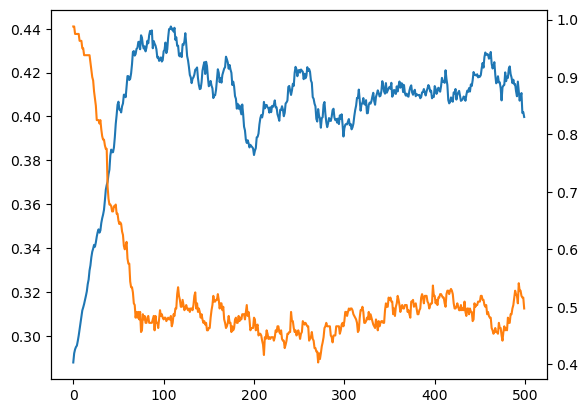

In [ ]:
plt.plot(np.median(ltc_series_tanh[:,1,:], axis=-1))
plt.gca().twinx().plot([x[6] for x in valence_series_tanh], color="tab:orange")

# basically, as soon as hex fraction is down to limiting value 0.4, median total anisotropy is maximal.


In [ ]:
## analysis of LTC trajectories - need to recompute so that the ids match over time

In [ ]:
elongation_tanh = np.sqrt(np.exp(delta_series_tanh[:,0])/np.exp(delta_series_tanh[:,1]))


In [ ]:
flipped_dict = {key: sum([(key in flips) for flips in last_flipped_edges_tanh]) for key in meshes_tanh[0].hes.keys()}
flipped_count = np.array(list(flipped_dict.values()))

In [ ]:
np.mean(flipped_count==0)

0.6456266907123535

In [ ]:
Counter(flipped_count[flipped_count>0])

Counter({2: 304, 1: 290, 3: 154, 4: 31, 5: 7})

(-13.077021480767055,
 13.64277028051521,
 -11.356864620994862,
 11.475426330706021)

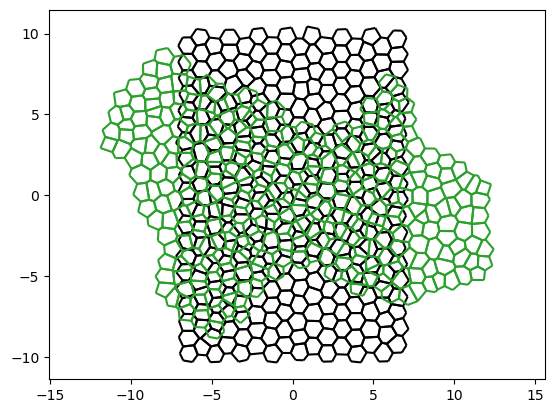

In [ ]:
meshes_tanh[0].cellplot()

meshes_tanh[500].cellplot(edge_colors={key: "tab:green" for key in mesh_initial.hes.keys()})

plt.axis("equal")

[<matplotlib.lines.Line2D>]

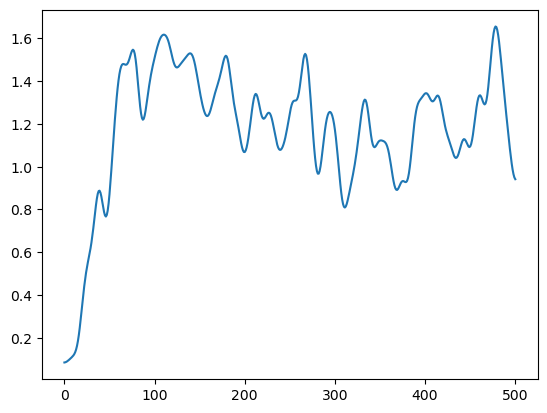

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate_tanh, sigma=5))

[<matplotlib.lines.Line2D>]

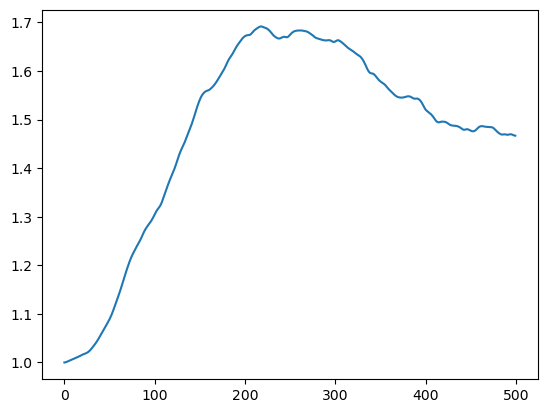

In [ ]:
plt.plot(elongation_tanh)

Text(0, 0.5, 'Median shape angle')

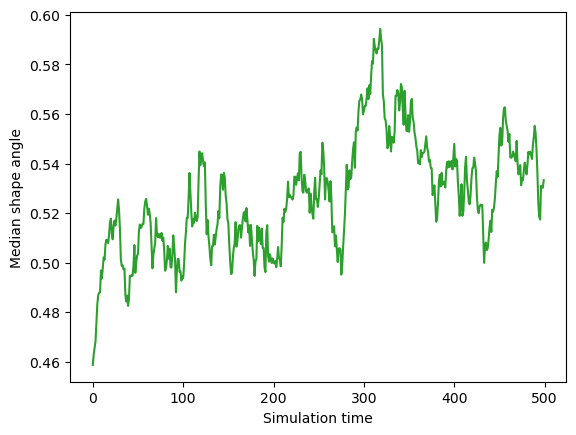

In [ ]:
plt.plot(np.median(ltc_series_tanh, axis=-1)[:,0] / np.pi, color="tab:green")

#plt.plot(ndimage.gaussian_filter1d(np.median(ltc_series_tanh, axis=-1)[:,0] / np.pi, sigma=30), color="tab:green", ls="dashed") 

plt.xlabel("Simulation time")
plt.ylabel("Median shape angle")

# no use for k_relax. doesn't appear to decrease the shape anlge at late times.

# repeating the simulation, there is no clear sign the final LTC angle is going down.

In [ ]:
np.mean(np.std(ltc_series_tanh[:,0]/np.pi, axis=-1) / np.sqrt(ltc_series_tanh.shape[2]))

# note: SEM is very low, 0.01. but simulation-to-simulation variation is much higher

0.01090544198907754

26.720778431774775

(-9.973578777580794, 9.512301299385804, -6.9891901201008935, 6.974267652068882)

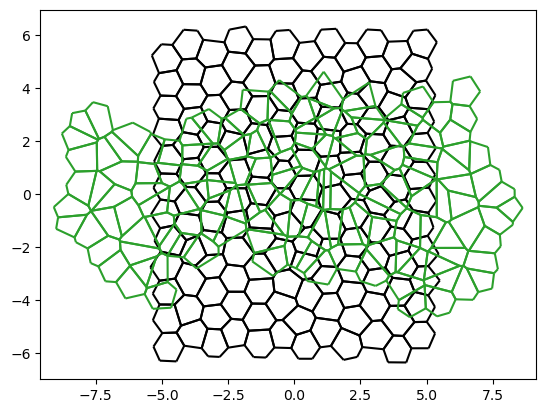

In [ ]:
meshes_tanh[0].cellplot()

meshes_tanh[500].cellplot(edge_colors={key: "tab:green" for key in mesh_initial.hes.keys()})

plt.axis("equal")

(-10.902543180454032, 10.295865913333209, -6.74308715848212, 5.678886117049013)

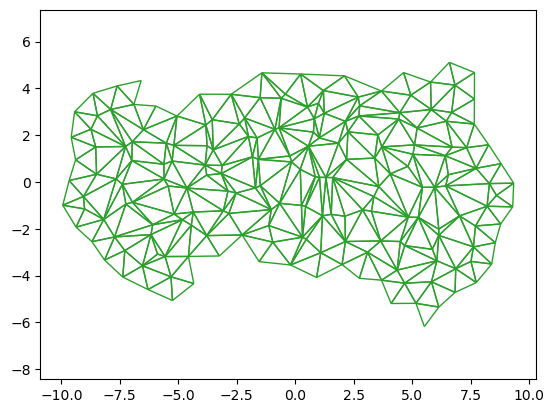

In [ ]:
meshes_tanh[500].triplot_color(edge_colors={key: "tab:green" for key in mesh_initial.hes.keys()})

plt.axis("equal")

[<matplotlib.lines.Line2D>]

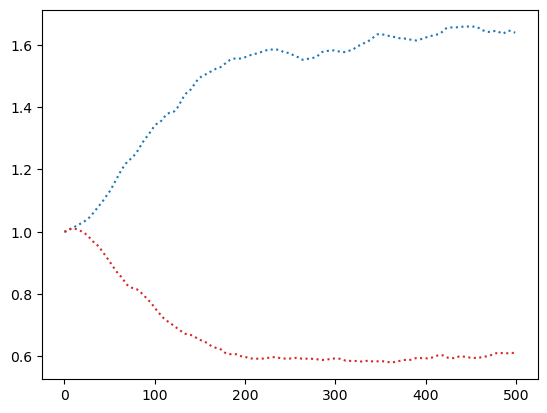

In [ ]:
plt.plot(np.exp(delta_series_tanh[:,0]), color="tab:blue", ls="dotted")
plt.plot(np.exp(delta_series_tanh[:,1]), color="tab:red", ls="dotted")


#plt.plot(np.exp(delta_series[:,0]), color="tab:blue")
#plt.plot(np.exp(delta_series[:,1]), color="tab:red")

Text(0, 0.5, 'Sqrt(Aspect ratio) change')

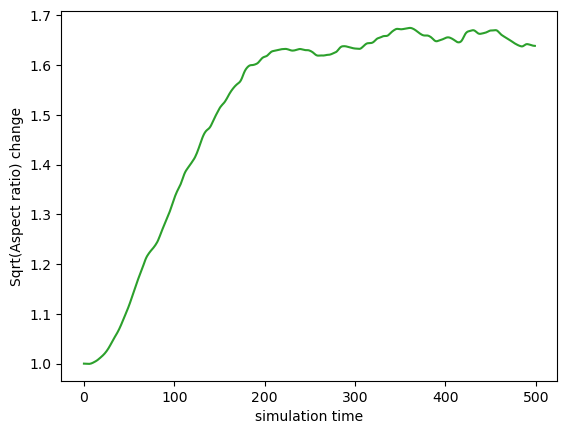

In [ ]:
plt.plot(np.sqrt(np.exp(delta_series_tanh[:,0])/ np.exp(delta_series_tanh[:,1])), color="tab:green")

#plt.plot(np.sqrt(np.exp(delta_series[:,0])/ np.exp(delta_series[:,1])), color="tab:blue")

plt.xlabel("simulation time")
plt.ylabel("Sqrt(Aspect ratio) change")

In [ ]:
# with scale = 2.5, T_c = 1.2 you get more efficient T1s - fewer t1s, but more coordinated.
# 2x fewer t1s, but only 1.2x less elongation

In [ ]:
np.sqrt(np.exp(delta_series[:,0])/ np.exp(delta_series[:,1]))[400] / np.sqrt(np.exp(delta_series_tanh[:,0])/ np.exp(delta_series_tanh[:,1]))[400]

1.2546940389504995

In [ ]:
np.sum(T1_rate[:400]) / np.sum(T1_rate_tanh[:400])

1.59073482428115

Text(0, 0.5, 'T1 rate')

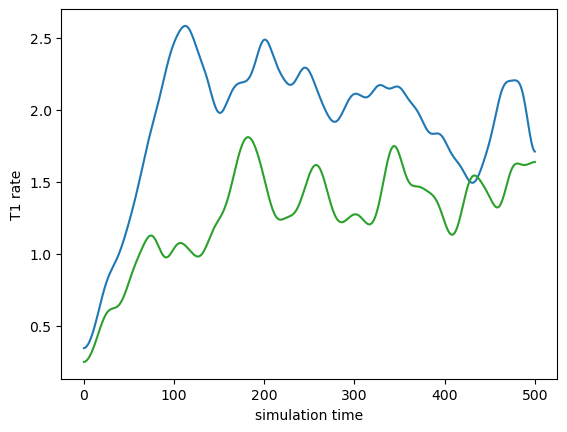

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate, sigma=10), color="tab:blue")
plt.plot(ndimage.gaussian_filter1d(T1_rate_tanh, sigma=10), color="tab:green")

plt.xlabel("simulation time")
plt.ylabel("T1 rate")

Text(0, 0.5, 'Median shape angle')

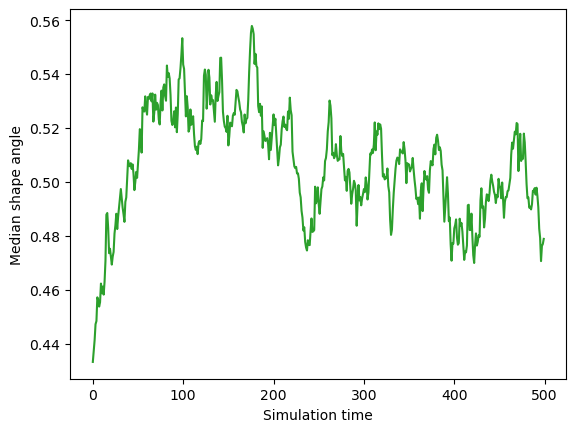

In [ ]:
#plt.plot(np.median(ltc_series, axis=-1)[:,0] / np.pi)

plt.plot(np.median(ltc_series_tanh, axis=-1)[:,0] / np.pi, color="tab:green")  # that's good, I suppose

plt.xlabel("Simulation time")
plt.ylabel("Median shape angle")

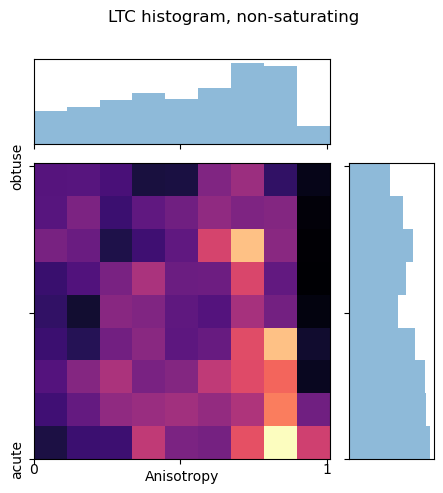

In [ ]:
fig = plt.figure(figsize=(5, 5))
fig.suptitle(f'LTC histogram, non-saturating', y=1.)

t0, t1 = (200, 250)

bins = [dln.eqspace(0, 1+.01, .1), dln.eqspace(0, 1+.01, .1)]
ax = dln.scatter_hist(ltc_series[t0:t1,1].flatten(), ltc_series[t0:t1,0].flatten()/np.pi, bins, fig=fig)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
#ax.set_aspect('equal', adjustable='box')
plt.show()

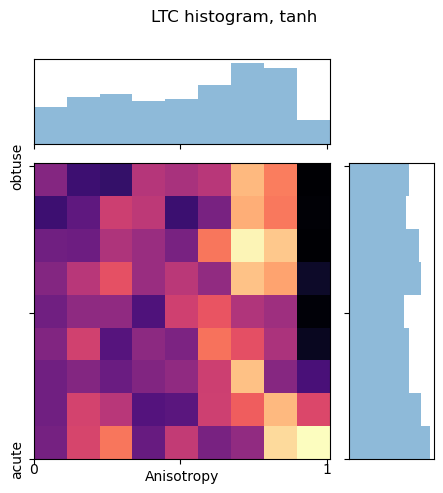

In [ ]:
fig = plt.figure(figsize=(5, 5))
fig.suptitle(f'LTC histogram, tanh', y=1.)

t0, t1 = (200, 250)

bins = [dln.eqspace(0, 1+.01, .1), dln.eqspace(0, 1+.01, .1)]
ax = dln.scatter_hist(ltc_series_tanh[t0:t1,1].flatten(), ltc_series_tanh[t0:t1,0].flatten()/np.pi, bins, fig=fig)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
#ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
## simulation loop - define as function to use joblib later.


def run_simulation_bridge(T_minus, T_c, T_plus, k=0.5, n_steps=n_steps, dt=dt, forbid_reflip=50,
                        keep_in_memory=False, log_rate=20, verbose=False):
    """Local function to run simulation. To save memory, keeping all meshes in RAM is optional."""
    # define the feedback parameters
    
    
    def params_pattern(fid):
        if fid in passive_ids:
            return {"T_minus": T_minus, "T_c": T_c, "T_plus": T_plus, "k": 4*k, "is_active": False} 
        return {"T_minus": T_minus, "T_c": T_c, "T_plus": T_plus, "k": k, "is_active": True} 
        
    # initialize the relevant quantities for the measurement
    ltc_series= []
    valence_series= []
    delta_series = []
    
    # set up simulation loop
    times = [0]
    last_flipped_edges = [[]]
    mesh = deepcopy(mesh_initial)
    mesh_previous = deepcopy(mesh)
    if keep_in_memory:
        meshes = [mesh_previous]
    else:
        meshes = [mesh_previous]
    
    mesh = deepcopy(meshes[-1])
    for i in tqdm(range(n_steps)):
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=saturating_dt_act_pass, params=params_pattern, rhs_rest_shape=None)
        # flatten triangulation
        sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, reset_intrinsic=True, return_sol=True)
        if sol["status"] != 0:
            break
            
        # set voronoi positions
        mesh.set_voronoi()
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False, optimizer_args=None)
        if verbose:
            if failed_flip:
                print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
            if flipped and not failed_flip:
                print(f"tpt {i}: flip {flipped}")
        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        if keep_in_memory:
            meshes.append(mesh_previous)
        if not keep_in_memory and ((i%log_rate) == 0) and (i > 0): # if I am not storing all meshes
            meshes.append(mesh_previous)
        # make measurements
        valence_series.append(ecm.get_valences(mesh))
        ltc_dist = tns.angles_shape(np.array(list(mesh.get_vertex_angles(exclude=None, method="dual").values())).T)
        ltc_series.append(ltc_dist)
        delta_series.append(get_width_height(mesh))
    # post-processing
    last_flipped_edges.append([])
    T1_rate = np.array([len(x) for x in last_flipped_edges[1:]]) / (dt*len(meshes[0].vertices))
    ltc_series = np.stack(ltc_series)
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[0])
    
    if keep_in_memory:
        return (T_minus, T_c, T_plus, meshes, last_flipped_edges, T1_rate, ltc_series, valence_series, delta_series)    
    
    else:
        return T_minus, T_c, T_plus, meshes, T1_rate, ltc_series, valence_series, delta_series

In [ ]:
dT = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0, T_c=1, T_plus=4))
                for fc in mesh_initial.faces.values()])
dT_bridge = np.median([np.linalg.norm(saturating_dt(np.array([he.rest for he in fc.hes]), T_minus=0.95, T_c=1, T_plus=4))
                      for fc in mesh_initial.faces.values()])



dT, dT_bridge, dT/dT_bridge

(0.5325307755518764, 0.06620620914585429, 8.043517102432114)

In [ ]:
%%time

# run a single simulation
timescale = 8



data_bridge = run_simulation_bridge(T_minus=0.95, T_c=1, T_plus=4, k=0.5/timescale, n_steps=500, dt=timescale*0.005, forbid_reflip=20,
                                    keep_in_memory=True, verbose=True)
_, _, _, meshes_bridge, last_flipped_edge_bridge, T1_rate_bridge, ltc_series_bridge, valence_series_bridge, delta_series_bridge = data_bridge

  0%|          | 0/500 [00:00<?, ?it/s]

tpt 1: flip [750]
tpt 3: flip [31]
tpt 4: flip [475, 784]
tpt 6: flip [525]
tpt 7: flip [340]
tpt 10: flip [61]
tpt 13: flip [453]
tpt 14: flip [925, 348]
tpt 15: flip [285, 960]
tpt 16: flip [883]
tpt 17: flip [987]
tpt 20: flip [685]
tpt 21: flip [1006]
tpt 22: flip [750, 735, 531]
tpt 23: flip [775]
tpt 24: flip [31]
tpt 25: flip [475, 784]
tpt 27: flip [525, 688]
tpt 28: flip [340, 628, 748]
tpt 30: flip [487]
tpt 31: flip [61]
tpt 32: flip [780]
tpt 34: flip [453]
tpt 35: flip [348, 925]
tpt 36: flip [285, 960, 921]
tpt 37: flip [883, 928]
tpt 38: flip [987]
tpt 41: flip [685, 607]
tpt 42: flip [1006, 249]
tpt 43: flip [735, 531]
tpt 44: flip [775]
tpt 45: flip [778]
tpt 47: flip [79]
tpt 48: flip [688, 433]
tpt 49: flip [748, 628]
tpt 50: flip [307]
tpt 51: flip [487, 492, 202]
tpt 52: flip [870, 331]
tpt 53: flip [780]
tpt 54: flip [972, 498]
tpt 55: flip [265]
tpt 57: flip [921]
tpt 58: flip [928]
tpt 60: flip [207]
tpt 62: flip [685, 607]
tpt 63: flip [249, 558]
tpt 64: flip [

tpt 419: flip [823, 960, 571]
tpt 420: flip [192]
tpt 421: flip [937, 202, 879, 75, 292, 768]
tpt 422: flip [261]
tpt 425: flip [487]
tpt 427: flip [1006]
tpt 429: flip [565]
tpt 430: flip [234, 870, 397]
tpt 431: flip [52, 207, 399, 742, 903]
tpt 432: flip [348, 79]
tpt 433: flip [951]
tpt 434: flip [910, 451, 183]
tpt 435: flip [340]
tpt 436: flip [829, 298]
tpt 437: flip [817, 607]
tpt 438: flip [492]
tpt 439: flip [699]
tpt 440: flip [571, 309, 960]
tpt 441: flip [192, 691]
tpt 442: flip [292, 768, 75]
tpt 444: flip [574]
tpt 445: flip [517]
tpt 446: flip [487]
tpt 447: flip [705, 202]
tpt 448: flip [1006]
tpt 449: flip [808]
tpt 450: flip [565]
tpt 451: flip [870, 397, 234]
tpt 452: flip [903, 742]
tpt 453: flip [348, 79, 814]
tpt 455: flip [183, 910, 451]
tpt 456: flip [340, 1008]
tpt 457: flip [298]
tpt 458: flip [607, 985]
tpt 459: flip [492]
tpt 460: flip [699]
tpt 462: flip [192, 691, 778]
tpt 463: flip [75, 331]
tpt 464: flip [160]
tpt 465: flip [574, 399, 993]
tpt 466: flip

(-6.89017878484256, 6.552505560298185, -6.4043451165003145, 6.454587585173577)

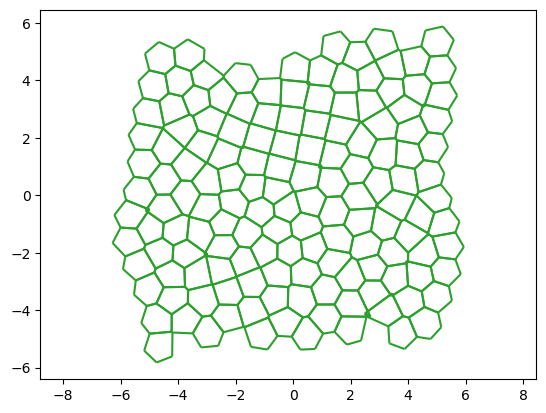

In [ ]:
#meshes_bridge[0].cellplot()

meshes_bridge[500].cellplot(edge_colors={key: "tab:green" for key in mesh_initial.hes.keys()})

plt.axis("equal")

# interesting, 4-fold order

No T-T_p gives 4-fold order 

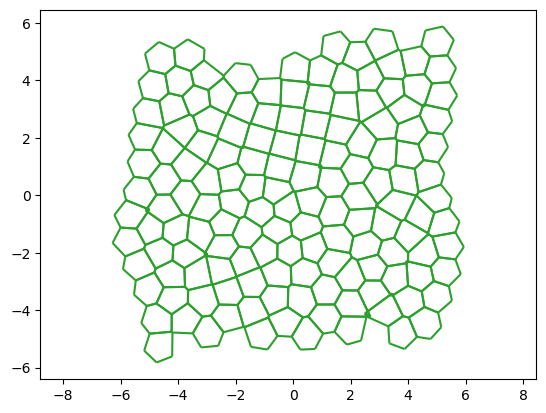

(-7.554481529375662, 7.170635894641036, -7.1358152558036805, 7.414951758388866)

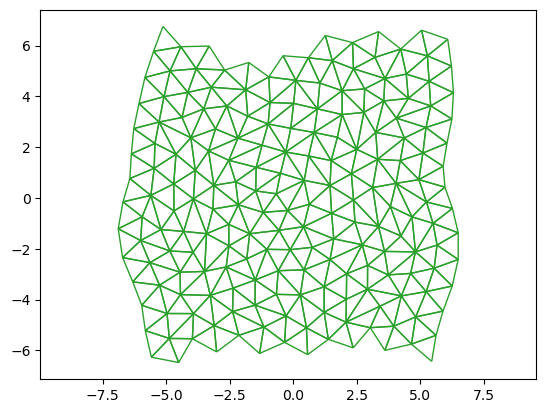

In [ ]:
meshes_bridge[500].triplot_color(edge_colors={key: "tab:green" for key in mesh_initial.hes.keys()})

plt.axis("equal")

Text(0, 0.5, 'Sqrt(Aspect ratio) change')

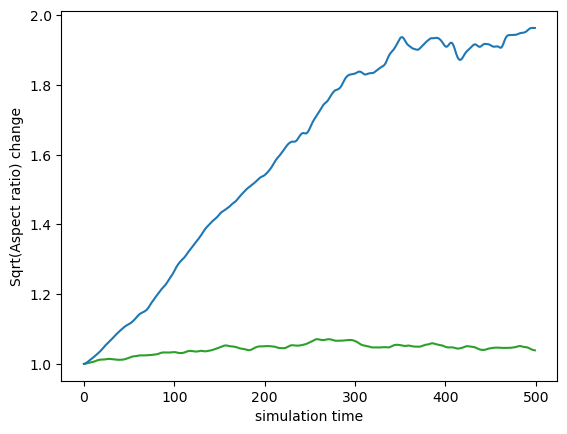

In [ ]:
plt.plot(np.sqrt(np.exp(delta_series_bridge[:,0])/ np.exp(delta_series_bridge[:,1])), color="tab:green")

plt.plot(np.sqrt(np.exp(delta_series[:,0])/ np.exp(delta_series[:,1])), color="tab:blue")

plt.xlabel("simulation time")
plt.ylabel("Sqrt(Aspect ratio) change")

Text(0, 0.5, 'T1 rate')

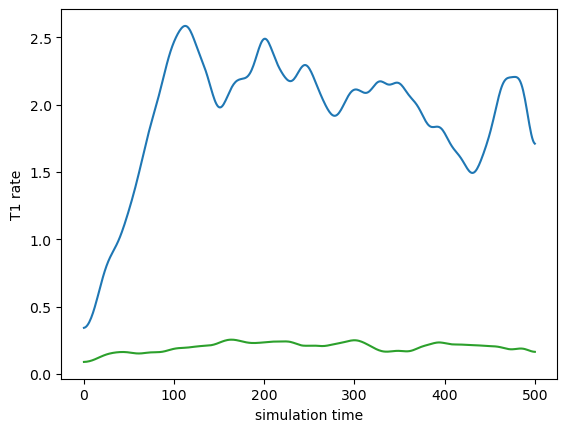

In [ ]:
plt.plot(ndimage.gaussian_filter1d(T1_rate, sigma=10), color="tab:blue")
plt.plot(ndimage.gaussian_filter1d(T1_rate_bridge, sigma=10), color="tab:green")

plt.xlabel("simulation time")
plt.ylabel("T1 rate")

In [ ]:
np.sqrt(np.exp(delta_series[:,0])/np.exp(delta_series[:,1]))[400]/np.sqrt(np.exp(delta_series_bridge[:,0])/np.exp(delta_series_bridge[:,1]))[400]

1.8211121394827798

In [ ]:
np.sum(T1_rate[:400]) / np.sum(T1_rate_bridge[:400])

9.757961783439491

Text(0, 0.5, 'Median shape angle')

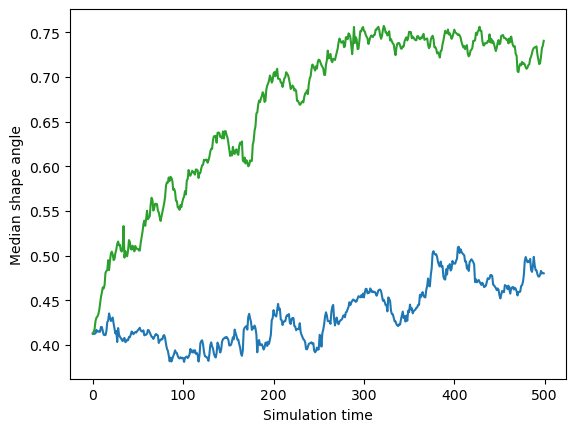

In [ ]:
plt.plot(np.median(ltc_series, axis=-1)[:,0] / np.pi)
plt.plot(np.median(ltc_series_bridge, axis=-1)[:,0] / np.pi, color="tab:green")

plt.xlabel("Simulation time")
plt.ylabel("Median shape angle")

Text(0, 0.5, 'Median anisotropy')

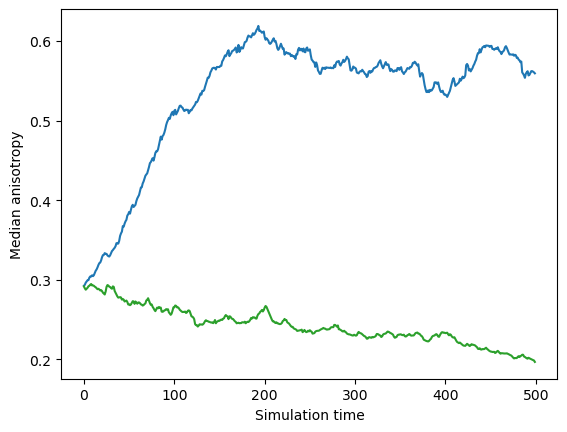

In [ ]:
plt.plot(np.median(ltc_series, axis=-1)[:,1])
plt.plot(np.median(ltc_series_bridge, axis=-1)[:,1], color="tab:green")

plt.xlabel("Simulation time")
plt.ylabel("Median anisotropy")